In this notebook we explore more about eye tracking data analysis

In [103]:
# Derived from:
#     https://www.axonlab.org/hcph-sops/data-management/eyetrack-qc
# Load the autoreload extension
%load_ext autoreload
# Set autoreload to update the modules every time before executing a new line of code
%autoreload 2

%matplotlib inline
from pathlib import Path
import json
import ppjson
from importlib import reload  # For debugging purposes

import numpy as np
import pandas as pd

import eyetrackingrun as et

from IPython.display import HTML
from matplotlib import animation
from matplotlib.animation import FuncAnimation, PillowWriter
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import copy
from write_bids_yiwei import EyeTrackingRun, write_bids, write_bids_from_df

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [104]:
subject_idx = 1
T_idx = 1

if T_idx == 1:
    mode = 'T1'
else:
    mode = 'T2'
    
BIDS_PATH = Path("/Users/cag/Documents/Dataset/MREyeTrack/EDF")

if subject_idx == 1:    
    FILE_NAME = f"000001_fixed_dot-16_grid_T1w_2024-10-14_17h24"    
elif subject_idx == 2:
    FILE_NAME = f"000002_fixed_dot-16_grid_T1w_2024-10-14_16h54" 
elif subject_idx == 3: 
    FILE_NAME = f"000003_fixed_dot-16_grid_T1w_2024-10-14_16h35"
    # "OT4.EDF"
else:
    FILE_NAME = f""
    
# D:\Eye_Dataset\Sub001\230928_anatomical_MREYE_study\ET_EDF
session = "001" #can be a string to be defined when required
tsv_name = f"{FILE_NAME}.tsv.gz"
gif_name = f'{FILE_NAME}.gif'


In [105]:
# Read in tsv.gz file
# Naming convension can be modified later
# recording_file = BIDS_PATH / "sub-001" / f"ses-{session}" / "dwi" / f"sub-001_ses-{session}_acq-highres_dir-RL_recording-eyetrack_physio.tsv.gz"
recording_file = BIDS_PATH / tsv_name
print(f'recording_file: {recording_file}')
recording = pd.read_csv(
    recording_file,
#     sep=r"\s+",
    sep="\t",
    na_values="n/a",
)
recording.head()
print(f'recording len: {len(recording)}')
metadata = json.loads((
    recording_file.parent
    / recording_file.name.replace(".tsv.gz", ".json")
).read_text())
# print(f'meta_data: {metadata}')

print('The duration of mri acquisition sub001 sub002 and sub003: 655240 ms')


recording_file: /Users/cag/Documents/Dataset/MREyeTrack/EDF/000001_fixed_dot-16_grid_T1w_2024-10-14_17h24.tsv.gz
recording len: 657900
The duration of mri acquisition sub001 sub002 and sub003: 655240 ms


# 1 Metadata and calibration

We always run a calibration before it is started. As a result, we will typically see the metadata corresponding to calibration on this particular run.

Now, let's print out the contents of the BIDS' sidecar JSON corresponding to the DWI in this session.

In [106]:

target_message = "ET: Start routine 'centered_dot'"
target_timestamp = 0
for index, element in enumerate(metadata['LoggedMessages']):
    if element[1] == target_message:
        print(f"First occurrence is at index {index}: {element}")
        target_timestamp = element[0]
        print(f"at timestamp {target_timestamp}")
        break
gap_start_dot = target_timestamp - metadata['StartTime']

# Here I don't consider the lag between start and the first stimuli anymore
# Start time = first trigger

# gap_start_dot = 0
print(f"Timestamp to start recording: {metadata['StartTime']}")
print(f'From the start of recording to the first dot: {gap_start_dot}')

First occurrence is at index 27: [15155843, "ET: Start routine 'centered_dot'"]
at timestamp 15155843
Timestamp to start recording: 15155345
From the start of recording to the first dot: 498


In [107]:
if subject_idx == 1:
    print(recording[655335:655338])
    # 655336 timestamp 15810681
    # From there it became NaN

        Unnamed: 0  eye1_x_coordinate  eye1_y_coordinate  eye1_pupil_size  \
655335      655335         443.899994         471.299988           1594.0   
655336      655336         443.899994         471.299988           1594.0   
655337      655337                NaN                NaN              NaN   

        eye1_pupil_x_coordinate  eye1_pupil_y_coordinate  \
655335                  -5161.0                  -2741.0   
655336                  -5161.0                  -2741.0   
655337                 -32768.0                 -32768.0   

        eye1_href_x_coordinate  eye1_href_y_coordinate  fast_href_x_velocity  \
655335                   434.0                  1691.0         -1.946136e+14   
655336                   434.0                  1691.0         -1.946136e+14   
655337                 -7936.0                 -7936.0         -1.946136e+14   

        fast_raw_x_velocity  screen_ppdeg_x_coordinate  \
655335         2.161728e+20                  26.700001   
655336       

In [108]:
t_axis = (
    recording.timestamp.values - recording.timestamp[0]
) / metadata["SamplingFrequency"]*1000
print(f"The end of the timestamp: {t_axis[-1]}")

The end of the timestamp: 657899.0


In [109]:
print(metadata["Columns"])
recording = recording.rename(
        columns={
            f"eye1_pupil_size": f"pupil_size",
            f"eye1_fixation": f"fixation",
            f"eye1_saccade": f"saccade",
            f"eye1_blink": f"blink",
            f"eye1_x_coordinate": f"x_coordinate", 
            f"eye1_y_coordinate": f"y_coordinate"         
        }
    )

metadata["Columns"] = recording.columns.tolist()
print(metadata["Columns"])

['eye1_x_coordinate', 'eye1_y_coordinate', 'eye1_pupil_size', 'eye1_pupil_x_coordinate', 'eye1_pupil_y_coordinate', 'eye1_href_x_coordinate', 'eye1_href_y_coordinate', 'fast_href_x_velocity', 'fast_raw_x_velocity', 'screen_ppdeg_x_coordinate', 'screen_ppdeg_y_coordinate', 'timestamp', 'eye1_fixation', 'eye1_saccade', 'eye1_blink']
['Unnamed: 0', 'x_coordinate', 'y_coordinate', 'pupil_size', 'eye1_pupil_x_coordinate', 'eye1_pupil_y_coordinate', 'eye1_href_x_coordinate', 'eye1_href_y_coordinate', 'fast_href_x_velocity', 'fast_raw_x_velocity', 'screen_ppdeg_x_coordinate', 'screen_ppdeg_y_coordinate', 'timestamp', 'fixation', 'saccade', 'blink']


In [110]:
recording.columns

Index(['Unnamed: 0', 'x_coordinate', 'y_coordinate', 'pupil_size',
       'eye1_pupil_x_coordinate', 'eye1_pupil_y_coordinate',
       'eye1_href_x_coordinate', 'eye1_href_y_coordinate',
       'fast_href_x_velocity', 'fast_raw_x_velocity',
       'screen_ppdeg_x_coordinate', 'screen_ppdeg_y_coordinate', 'timestamp',
       'fixation', 'saccade', 'blink'],
      dtype='object')

In [111]:
# See cleaned cell 4

In [112]:
plot_pupil_saccade = False

if plot_pupil_saccade:
    fig = plt.figure(figsize=(16, 2))

    plt.plot(
        t_axis,
        recording["pupil_size"].values,
    )

    plt.plot(
        t_axis,
        recording["saccade"].values * 5000,
    )

    plt.xlabel("time [s]")
    plt.ylabel("pupil area [a.u.]")
    plt.xlim((200, 220))
    plt.title('Pupil area and saccading')
    print(f'At this time, since blinking is detected, we cannot get clear pupil area ?')

In [113]:
plot_x_saccade = False
if plot_x_saccade:
    fig = plt.figure(figsize=(16, 2))
    plt.plot(
        t_axis,
        recording["x_coordinate"].values,
    )

    plt.plot(
        t_axis,
        recording["saccade"].values * 1000,
    )
    plt.xlim((200, 220))

Check fixation

In [114]:
plot_fixation = False
if plot_fixation:
    # Fixation
    fig = plt.figure(figsize=(16, 2))
    plt.plot(
        t_axis,
        recording["x_coordinate"].values,
    )

    plt.plot(
        t_axis,
        recording["fixation"].values * 500,
    )
    plt.xlim((340, 350))
    plt.title('X coordinate of gazing with fixation')

    fig = plt.figure(figsize=(16, 2))
    plt.plot(
        t_axis,
        recording["y_coordinate"].values,
    )

    plt.plot(
        t_axis,
        recording["fixation"].values * 500,
    )
    plt.xlim((340, 350))
    plt.title('Y coordinate of gazing with fixation')

The analysis did not reveal a strong correlation between pupil size and saccade or fixation events.

The coordinate sequence is stable during fixation, we should extract the data in the event.

# 2 Data Cleaning

- Seperate the two phases of sequences
- Extract the X Y coordinates
- Eliminate the blinking and non-fixation area of LIBRE data, and keep the raw data of STANDARD.Because there is no mechanism for the second STANDARD one to correct the eye fixation.
- Design some criteria for cleaning the noise data
    - Visual angle
    - Heat maps
    - Fixation algorithm (literature review)

## 2.1 Seperate the two phases of sequences

In [115]:
# -----------------------------
reset_index_bool = False
eliminate_all_nan = False
eliminate_first_nan = False
# -----------------------------

size = (
    metadata["ScreenAOIDefinition"][1][1],
    metadata["ScreenAOIDefinition"][1][3],
)

coor_data = recording[["x_coordinate", "y_coordinate"]]
print(f"Extract X Y coordinates from recording: {len(coor_data)}")

if eliminate_all_nan:
    coor_data = coor_data[coor_data.x_coordinate.notna() & coor_data.y_coordinate.notna()]
    coor_recording = recording[recording.x_coordinate.notna() & recording.y_coordinate.notna()]
elif eliminate_first_nan:
    # Find the first non-NaN row
    first_valid_index = coor_data[['x_coordinate', 'y_coordinate']].dropna(how='all').index[0]

    # Slice the DataFrame from the first non-NaN row onward
    coor_data = coor_data.iloc[first_valid_index:]
    
    coor_recording = recording.iloc[first_valid_index:]
    
else:
    coor_recording = recording

if reset_index_bool:
    coor_data.reset_index(drop=True, inplace=True)
    coor_recording.reset_index(drop=True, inplace=True)
    
print(coor_data)
print(f"Eliminating nan values? {eliminate_first_nan}: {len(coor_data)}")
print(f'len of coor_data {len(coor_data)} should be equal to len of coor_recording {len(coor_recording)}')

Extract X Y coordinates from recording: 657900
        x_coordinate  y_coordinate
0         466.899994    279.200012
1         466.899994    279.899994
2         466.899994    279.799988
3         465.500000    280.399994
4         464.100006    281.000000
...              ...           ...
657895           NaN           NaN
657896           NaN           NaN
657897           NaN           NaN
657898           NaN           NaN
657899           NaN           NaN

[657900 rows x 2 columns]
Eliminating nan values? False: 657900
len of coor_data 657900 should be equal to len of coor_recording 657900


In [116]:
# Duration setting according to the protocol (in sec) not any more
# Duration setting according to the raw data info


T1_LIBRE = (len(coor_data))/metadata['SamplingFrequency']
    
T1_GAP = 0
T1_VIBE = 0


print(f"The length of T1_LIBRE Subject{subject_idx} should be: {T1_LIBRE} sec (len(coor_data)-gap_start_dot)")


The length of T1_LIBRE Subject1 should be: 657.9 sec (len(coor_data)-gap_start_dot)


mode: T1
set start margin as 0
657900


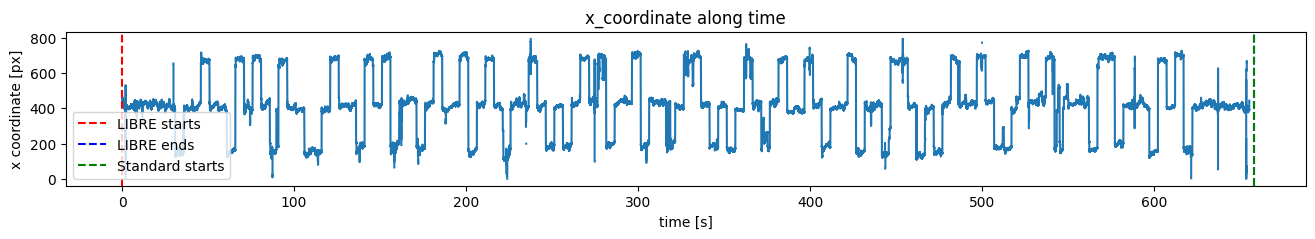

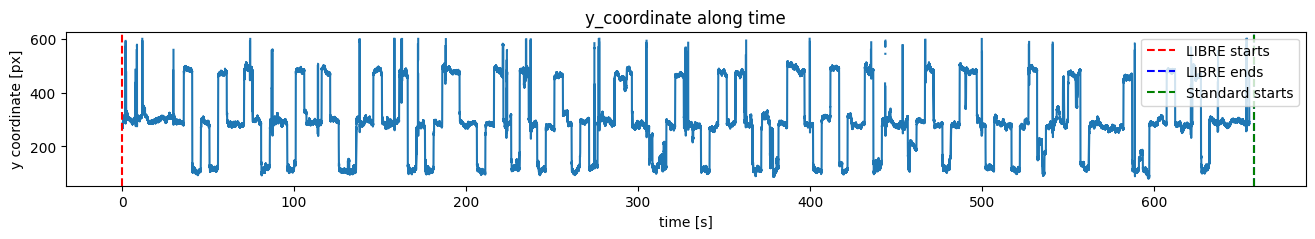

In [117]:
start_margin = 0
if mode == 'T1':
    print(f'mode: {mode}')
    print(f"set start margin as {start_margin}")
    T1_LIBRE_sample = T1_LIBRE*metadata['SamplingFrequency']
    T1_GAP_sample = T1_GAP*metadata['SamplingFrequency']
    T1_VIBE = len(coor_data) - T1_LIBRE_sample - T1_GAP_sample
else:
    print(f'mode: {mode}')
    print(f"set start margin as {start_margin}")
    T2_LIBRE_sample = T2_LIBRE*metadata['SamplingFrequency']
    T2_GAP_sample = T2_GAP*metadata['SamplingFrequency']
    T2_TSE = len(coor_data) - T2_LIBRE_sample - T2_GAP_sample
    


t_axis_xy = (
    coor_data.index 
) / metadata["SamplingFrequency"]

# x coordinate
fig = plt.figure(figsize=(16, 2))

plt.plot(
    t_axis_xy,
    coor_data["x_coordinate"].values,
)

if mode == 'T1':
    plt.axvline(x=start_margin/metadata["SamplingFrequency"], color='r', linestyle='--', label='LIBRE starts')
    plt.axvline(x=(T1_LIBRE_sample+start_margin)/metadata["SamplingFrequency"], color='b', linestyle='--', label='LIBRE ends')
    plt.axvline(x=(T1_LIBRE_sample+start_margin+T1_GAP_sample)/metadata["SamplingFrequency"], color='g', 
                linestyle='--', label='Standard starts')
else:
    plt.axvline(x=start_margin/metadata["SamplingFrequency"], color='r', linestyle='--', label='LIBRE starts')
    plt.axvline(x=(T2_LIBRE_sample+start_margin)/metadata["SamplingFrequency"], color='b', linestyle='--', label='LIBRE ends')
    plt.axvline(x=(T2_LIBRE_sample+start_margin+T2_GAP_sample)/metadata["SamplingFrequency"], color='g', 
                linestyle='--', label='Standard starts')
    
plt.title("x_coordinate along time")
plt.xlabel("time [s]")
plt.ylabel("x coordinate [px]")
plt.legend()

# y coordinate
fig = plt.figure(figsize=(16, 2))

plt.plot(
    t_axis_xy,
    coor_data["y_coordinate"].values,
)

plt.axvline(x=start_margin/metadata["SamplingFrequency"], color='r', linestyle='--', label='LIBRE starts')
plt.axvline(x=(T1_LIBRE_sample+start_margin)/ metadata["SamplingFrequency"], color='b', linestyle='--', label='LIBRE ends')
plt.axvline(x=(T1_LIBRE_sample+start_margin+T1_GAP_sample)/metadata["SamplingFrequency"], color='g', 
            linestyle='--', label='Standard starts')

    
plt.title("y_coordinate along time")
plt.xlabel("time [s]")
plt.ylabel("y coordinate [px]")
plt.legend()


coor_data_LIBRE = coor_data[start_margin:int(T1_LIBRE_sample)+start_margin] 
coor_recording_LIBRE = coor_recording[start_margin:int(T1_LIBRE_sample)+start_margin] 
coor_data_LIBRE_raw = copy.deepcopy(coor_data_LIBRE)
print(len(coor_data_LIBRE))


In [118]:
# import scipy.io
# coor_array = coor_data_LIBRE[['x_coordinate', 'y_coordinate']].to_numpy()
# scipy.io.savemat(f'coor_data_raw_t1w_libre_sub00{subject_idx}.mat', {'coordinates': coor_array})

## 2.2 Eliminating blinking

In [119]:
use_eliminate_blink = True

def eliminate_blink(coor_data, coor_recording, seq_name):
#     coor_data = coor_data[coor_recording.blink < 1]
#     coor_recording = coor_recording[coor_recording.blink < 1]
# Note: instead of filtering them out, I assign nan to the invalid elements
    print(f'The data will be eliminated: {len(coor_data[coor_recording.blink > 0])}')
    coor_data.loc[coor_recording.blink > 0,  ['x_coordinate', 'y_coordinate']] = np.nan
    coor_recording.loc[coor_recording.blink > 0,  ['x_coordinate', 'y_coordinate']] = np.nan
    print(f'After eliminating blinking: \nlen of coor_data_{seq_name} {len(coor_data)} \
      should be equal to len of coor_recording {len(coor_recording)}')
    return coor_data, coor_recording


if use_eliminate_blink:
    coor_data_LIBRE,  coor_recording_LIBRE = eliminate_blink(coor_data_LIBRE, coor_recording_LIBRE, 'LIBRE')
# coor_data_STANDARD,  coor_recording_STANDARD = eliminate_blink(coor_data_STANDARD, 
#                                                                coor_recording_STANDARD, 'STANDARD')
plot_heatmap = False
if plot_heatmap:
    import plot
    plot.plot_heatmap_coordinate(coor_data_LIBRE, density=False, screen_size=size, 
                                 title='LIBRE: The gaze from the beginning to the end')
    plot.plot_heatmap_coordinate(coor_data_STANDARD, density=False, screen_size=size, 
                                 title='STANDARD: The gaze from the beginning to the end')

The data will be eliminated: 11775
After eliminating blinking: 
len of coor_data_LIBRE 657900       should be equal to len of coor_recording 657900


In [120]:
# coor_data_LIBRE[coor_recording_LIBRE.blink > 0]

## 2.3 Preserving fixation

In [121]:
use_preserve_fixation = True

def preserve_fixation(coor_data, coor_recording, seq_name):
#     coor_data = coor_data[coor_recording.fixation > 0]
#     coor_recording = coor_recording[coor_recording.fixation > 0]
    print(f'The data will be eliminated: {len(coor_data[coor_recording.fixation < 1])}')
    coor_data.loc[coor_recording.fixation < 1, ['x_coordinate', 'y_coordinate']] = np.nan
    coor_recording.loc[coor_recording.fixation < 1, ['x_coordinate', 'y_coordinate']] = np.nan

    print(f'After preserving fixation: \nlen of coor_data_{seq_name} {len(coor_data)} \
      should be equal to len of coor_recording {len(coor_recording)}')
    return coor_data, coor_recording


if use_preserve_fixation:
    coor_data_LIBRE,  coor_recording_LIBRE = preserve_fixation(coor_data_LIBRE, coor_recording_LIBRE, 'LIBRE')
    # coor_data_STANDARD,  coor_recording_STANDARD = preserve_fixation(coor_data_STANDARD, 
    #                                                                coor_recording_STANDARD, 'STANDARD')
plot_heatmap = False
if plot_heatmap:
    import plot
    plot.plot_heatmap_coordinate(coor_data_LIBRE, density=False, screen_size=size, 
                                 title='LIBRE: The gaze from the beginning to the end')
    plot.plot_heatmap_coordinate(coor_data_STANDARD, density=False, screen_size=size, 
                                 title='STANDARD: The gaze from the beginning to the end')

The data will be eliminated: 30428
After preserving fixation: 
len of coor_data_LIBRE 657900       should be equal to len of coor_recording 657900


## 2.4 Plot the gazing dots

In [122]:
# see cleaned_cell [1]

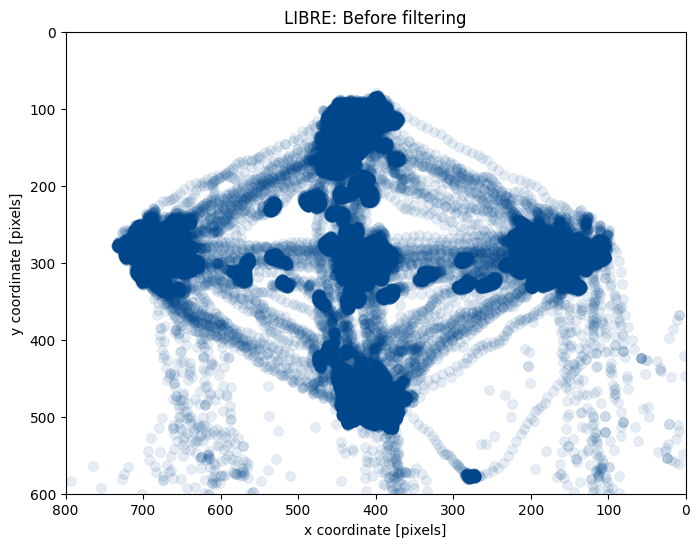

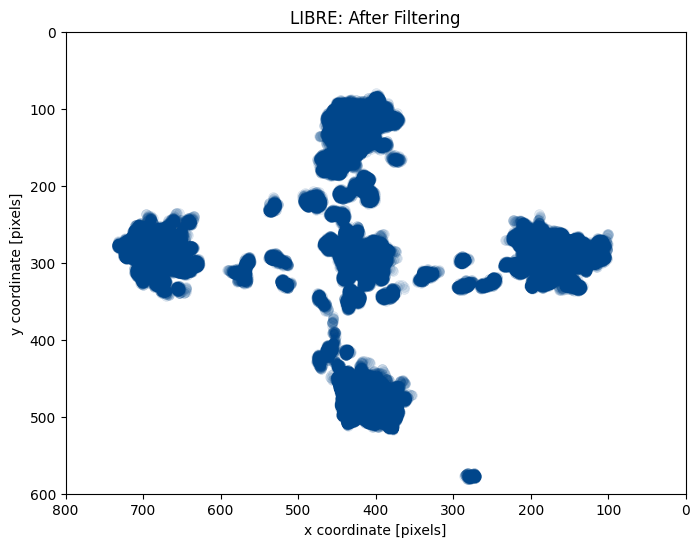

In [123]:
# Example data (replace with your actual data)
X_coord = coor_data_LIBRE_raw['x_coordinate']
Y_coord = coor_data_LIBRE_raw['y_coordinate']
fig, ax= plt.subplots(figsize=(8, 6))
# Plot the data, flipping X coordinates and using dots as markers
plt.scatter(X_coord, Y_coord, s=50, c='#00468b', alpha=0.1, edgecolors='#00468b', linewidth=0.5)
plt.xlim((0, 800))
plt.ylim((0, 600))
# Set plot title
plt.title('LIBRE: Before filtering')
plt.xlabel('x coordinate [pixels]')
plt.ylabel('y coordinate [pixels]')
# Reverse the direction of the Y-axis
plt.gca().invert_yaxis()
plt.gca().invert_xaxis()

# ============================================================
# Example data (replace with your actual data)
X_coord = coor_data_LIBRE['x_coordinate']
Y_coord = coor_data_LIBRE['y_coordinate']
fig, ax= plt.subplots(figsize=(8, 6))
# Plot the data, flipping X coordinates and using dots as markers
plt.scatter(X_coord, Y_coord, s=50, c='#00468b', alpha=0.1, edgecolors='#00468b', linewidth=0.5)
plt.xlim((0, 800))
plt.ylim((0, 600))
# Set plot title
plt.title('LIBRE: After Filtering')
plt.xlabel('x coordinate [pixels]')
plt.ylabel('y coordinate [pixels]')
# Reverse the direction of the Y-axis
plt.gca().invert_yaxis()
plt.gca().invert_xaxis()
# ============================================================



By far, we initially cleaned data based on the inherent properties in the metadata from EyeLink. And we plotted the fixation evaluation. 

In [124]:
# see cleaned_cell [2]

## 2.5 Visualize gaze groups

In [125]:

def within_2d_range(x_vals, y_vals, x_range, y_range):
    return np.sum((x_vals >= x_range[0]) & (x_vals <= x_range[1]) &
                      (y_vals >= y_range[0]) & (y_vals <= y_range[1]))
    


def label_correction(labels, counts, intervals):

    interval_len = len(labels)
    if intervals == 5000:
        intervals = [intervals]*interval_len
        print(intervals)
    print(f'len of intervals {interval_len} in label_correction')
    corrected_labels = []
    for i, label in enumerate(labels):
        if (label=='center') & (i>5) & (i<interval_len-1-5):
            label='invalid'
            print(f'index-{i}: label corrected, at this time there is no center stimulus ')
        if counts[i]<intervals[i]/2:
            label='invalid'
            print(f'index-{i}: label corrected, count of valid points is less than half of interval')
        corrected_labels.append(label)

    return corrected_labels
            
    

In [126]:
# see cleaned_cell [3]

Subjects saccaded from one position to another need a short delay, so the actual gaze points are not necessarily aligned with the stimuli occurring. We need to adjust a bit or tolerate such delay.

Classification

In [127]:
# More detailed classification
# play with the timestamp and the first fixation point -> finer subject delay.
metadata['LoggedMessages']

dot_message_1 = "ET: Start routine 'centered_dot'"
dot_message_2 = "ET: Start routine 'dots'"
dot_message_3 = 'ET: dot moved!'


dot_message = []
for index, element in enumerate(metadata['LoggedMessages']):
    if (element[1] == dot_message_1) or (element[1] == dot_message_2) or (element[1] == dot_message_3):
        dot_message.append(element)

print(f'total length: {len(dot_message)}')

start_timestamp = metadata['StartTime']
first_dot_timestamp = dot_message[0][0]
dot_message = [[timestamp - start_timestamp, msg] for timestamp, msg in dot_message]
# dot_message = [[timestamp, msg] for timestamp, msg in dot_message]
print('Shifted')
print(dot_message[-1])

print(dot_message)

total length: 131
Shifted
[651901, "ET: Start routine 'centered_dot'"]
[[498, "ET: Start routine 'centered_dot'"], [5489, "ET: Start routine 'centered_dot'"], [10489, "ET: Start routine 'centered_dot'"], [15490, "ET: Start routine 'centered_dot'"], [20506, "ET: Start routine 'centered_dot'"], [25506, "ET: Start routine 'centered_dot'"], [30506, "ET: Start routine 'dots'"], [35506, 'ET: dot moved!'], [40507, 'ET: dot moved!'], [45524, 'ET: dot moved!'], [50540, "ET: Start routine 'dots'"], [55557, 'ET: dot moved!'], [60573, 'ET: dot moved!'], [65574, 'ET: dot moved!'], [70590, "ET: Start routine 'dots'"], [75606, 'ET: dot moved!'], [80607, 'ET: dot moved!'], [85623, 'ET: dot moved!'], [90624, "ET: Start routine 'dots'"], [95640, 'ET: dot moved!'], [100657, 'ET: dot moved!'], [105658, 'ET: dot moved!'], [110677, "ET: Start routine 'dots'"], [115691, 'ET: dot moved!'], [120707, 'ET: dot moved!'], [125708, 'ET: dot moved!'], [130709, "ET: Start routine 'dots'"], [135725, 'ET: dot moved!'],

In [128]:
def classify_gaze_region_v2(X_coord, Y_coord, dot_message, sb_delay=0, display=False):
    from collections import Counter
    
    time_len = len(X_coord)
    print(f'time length: {len(X_coord)}')
    # label the dot position
    x_left_range = [600,800]
    x_right_range = [0, 200]
    x_center_range = [300, 500]
    
    y_up_range = [0, 200]
    y_down_range = [400, 600]
    y_center_range = [200, 400]
    labels = []
    counts = []

     
    if dot_message == []:
        interval = 5000
        default_range = range(sb_delay, int(time_len), interval)
        time_range = default_range
        print('default time range')
        intervals = [interval] * len(default_range)
        
    else:
        print(f'len of dot messages {len(dot_message)}')
        dot_time_range = [item[0]+sb_delay for item in dot_message]
        time_range = dot_time_range
        time_range.append(dot_time_range[-1])
        print('time range with ET message')

        # Extract the time values (first elements of each pair)
        time_values = [item[0] for item in dot_message]
        
        # Compute the time intervals
        intervals = [time_values[i] - time_values[i - 1] for i in range(1, len(time_values))]
        intervals.append(5000)
        print(f'Before appending: time duration of intervals: {sum(intervals)}')
        for i in range(10):
            if len(intervals) != len(time_range):
                intervals.append(5000)
                print('append +1 interval')
            else:
                break
        print("Time Intervals:", intervals)
        print(f'len of intervals: {len(intervals)}')

    print(f'length of time_range {len(time_range)}')
    
    for start_time, interval in zip(time_range, intervals):
        end_time = start_time + interval
        x_interval = X_coord[start_time:end_time]
        y_interval = Y_coord[start_time:end_time]
        
        # Calculate counts for each region
        left_count = within_2d_range(x_interval, y_interval, x_left_range, y_center_range)
        right_count = within_2d_range(x_interval, y_interval, x_right_range, y_center_range)
        center_count = within_2d_range(x_interval, y_interval, x_center_range, y_center_range)
        up_count = within_2d_range(x_interval, y_interval, x_center_range, y_up_range)
        down_count = within_2d_range(x_interval, y_interval, x_center_range, y_down_range)
    
        region_counts = {
            'left': left_count,
            'right': right_count,
            'center': center_count,
            'up': up_count,
            'down': down_count,
        }
        
        max_label, max_count = max(region_counts.items(), key=lambda item: item[1])
        # Append the result
        if max_count > 0:
            labels.append(max_label)
            counts.append(max_count)
        else:
            labels.append('unknown')
            counts.append(0)
        
    if display:
        for i, label in enumerate(labels):
            print(f'Interval {i}-{(i+1)}: {label} -> {counts[i]}')

    return labels, counts, intervals



time length: 657900
len of dot messages 131
time range with ET message
Before appending: time duration of intervals: 656403
append +1 interval
Time Intervals: [4991, 5000, 5001, 5016, 5000, 5000, 5000, 5001, 5017, 5016, 5017, 5016, 5001, 5016, 5016, 5001, 5016, 5001, 5016, 5017, 5001, 5019, 5014, 5016, 5001, 5001, 5016, 5018, 5015, 5018, 5015, 5017, 5001, 5016, 5016, 5001, 5017, 5017, 5017, 5015, 5001, 5017, 5001, 5015, 5002, 5016, 5016, 5001, 5015, 5002, 5016, 5018, 5015, 5018, 5016, 5000, 5017, 5017, 5016, 5000, 5017, 5001, 5016, 5000, 5017, 5001, 5016, 5016, 5017, 5001, 5016, 5000, 5000, 5019, 5014, 5017, 5001, 5017, 5017, 5016, 5017, 5017, 5016, 5017, 5002, 5016, 5015, 5001, 5000, 5017, 5016, 5017, 5017, 5017, 5016, 5017, 5000, 5017, 5016, 5001, 5016, 5018, 5015, 5001, 5017, 5016, 5017, 5017, 5000, 5001, 5016, 5017, 5016, 5001, 5016, 5000, 5016, 5002, 5016, 5016, 5002, 5003, 5013, 5016, 5017, 5019, 4999, 5001, 4999, 5000, 5000, 5000]
len of intervals: 132
length of time_range 132
l

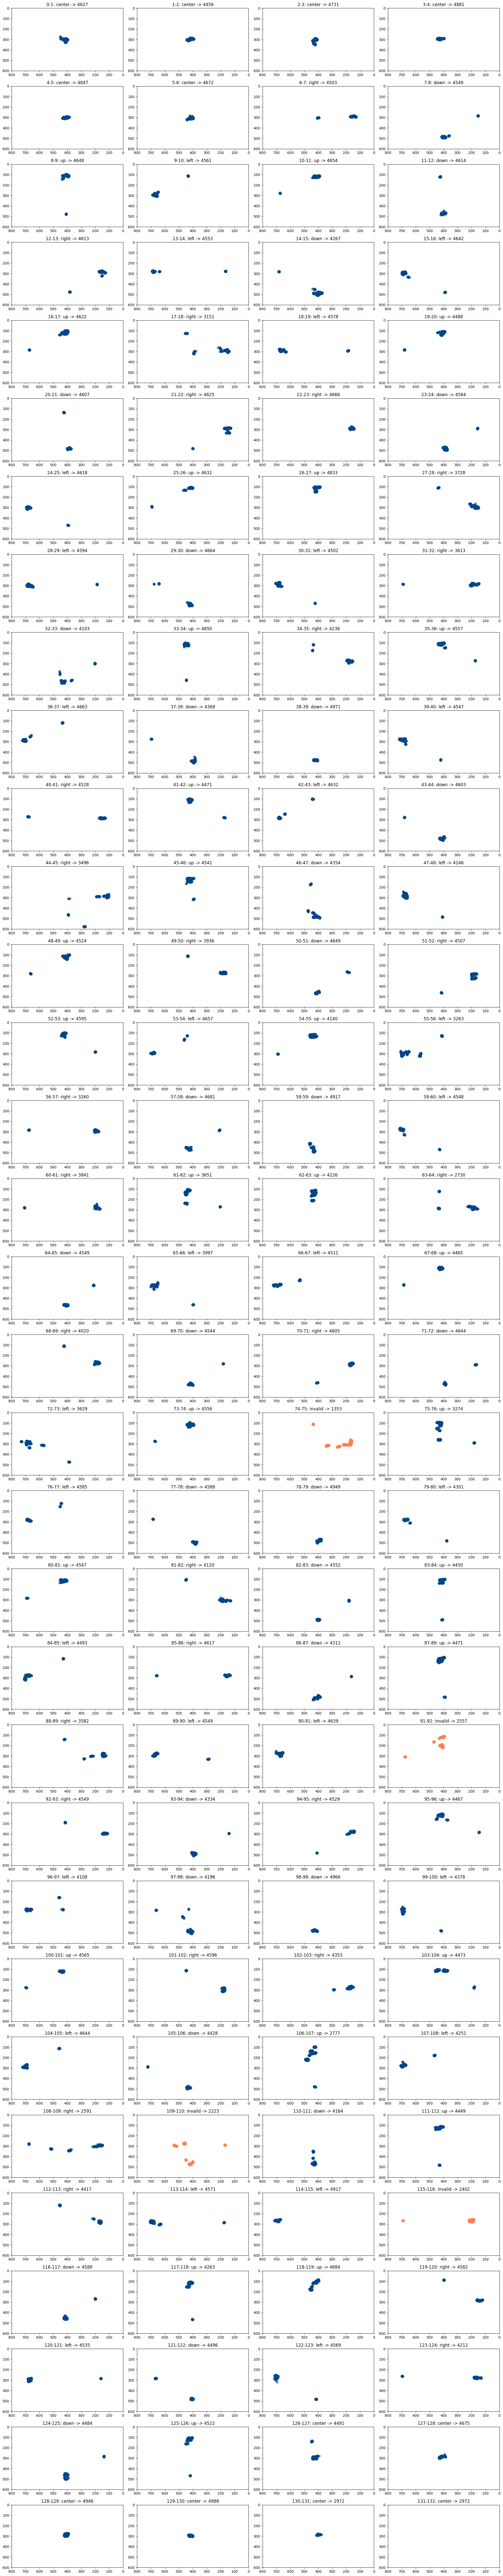

In [129]:
import json
X_coord = coor_data_LIBRE['x_coordinate']
Y_coord = coor_data_LIBRE['y_coordinate']
labels,counts, intervals = classify_gaze_region_v2(X_coord, Y_coord, dot_message, sb_delay=0, display=False)

with open(f'./labels/labels_subj_00{subject_idx}.json', 'w') as file:
    json.dump(labels, file)
    
corr_labels = label_correction(labels, counts, intervals)
with open(f'./labels/corrected_labels_subj_00{subject_idx}.json', 'w') as file:
    json.dump(corr_labels, file)

sb_delay = 0
num_rows=33
num_cols=4
fig, axes = plt.subplots(num_rows, num_cols, figsize=(4*(num_cols+1), 3*(num_rows+1)))
axes = axes.flatten()
invalid_indices = [i for i, element in enumerate(corr_labels) if element == "invalid"]
print(invalid_indices)
  
for i, ax in enumerate(axes):
    if i<len(dot_message):
        x = X_coord[dot_message[i][0]+sb_delay:dot_message[i][0]+sb_delay+intervals[i]]
        y = Y_coord[dot_message[i][0]+sb_delay:dot_message[i][0]+sb_delay+intervals[i]]
    else:
        x = X_coord[dot_message[-1][0]+sb_delay+intervals[-1]:]
        y = Y_coord[dot_message[-1][0]+sb_delay+intervals[-1]:]
        
    if i in invalid_indices:
        ax.scatter(x, y, c='coral', alpha=0.1, edgecolors='coral')
    else:
        ax.scatter(x, y, c='#00468b', alpha=0.1, edgecolors='#00468b')
    ax.set_title(f'{i}-{i+1}: {corr_labels[i]} -> {counts[i]}')
    ax.set_xlim([0, 800])
    ax.set_ylim([0, 600])
    ax.invert_xaxis()
    ax.invert_yaxis()

plt.tight_layout()
plt.show()

In [136]:
def cal_diff_distance(x_coord, y_coord):
    
    # Calculate differences
    # * 81.3 / 176
    # * 62 / 137
    dx = np.diff(x_coord)  # Difference in x
    dy = np.diff(y_coord)   # Difference in y
    
    # Check for NaN values, ravel() is the must
   
    nan_mask = (
    np.isnan(x_coord[:-1]).ravel() |
    np.isnan(x_coord[1:]).ravel()  |
    np.isnan(y_coord[:-1]).ravel() |
    np.isnan(y_coord[1:]).ravel()
    )
    
    # Calculate Euclidean distances
    distances = np.sqrt(dx**2 + dy**2)
    # Apply NaN mask

    distances[nan_mask] = np.nan

    
    return distances

def cal_diff_sum_window(x_coord, y_coord, window_size=7):
    # Calculate differences
    # * 81.3 / 176
    # * 62 / 137
    distances = cal_diff_distance(x_coord, y_coord)
    half_window = window_size // 2

    # Create an empty array to store the sum of each window
    window_sums = []
    for i in range(len(x_coord)):
        # Get the start and end indices of the window
        start_idx = max(0, i - half_window)
        end_idx = min(len(distances), i + half_window + 1)
        
        # Slice the array and calculate the sum of the window
        window_sum = np.nansum(distances[start_idx:end_idx])
        
        # Append the window sum to the result list
        window_sums.append(window_sum)
    
    # Convert the list of sums to a numpy array for easier manipulation
    window_sums = np.array(window_sums)
    
    return window_sums


def calculate_max_pairwise_distance(x_coord, y_coord):
    """
    Calculate the maximum Euclidean distance between each pair of coordinates.

    Args:
    coords (numpy.ndarray): An array of shape (n, 2), where n is the number of coordinates, 
                            and each row contains (x, y) coordinates.

    Returns:
    float: The maximum distance between any pair of coordinates.
    """
    
    coords = np.column_stack((x_coord, y_coord))
    diffs = coords[:, np.newaxis, :] - coords[np.newaxis, :, :]  # Shape (n, n, 2)
    
    # Compute Euclidean distances for all pairs
    distances = np.sqrt(np.nansum(diffs**2, axis=-1))  # Shape (n, n)
    
    # Find the maximum distance
    max_distance = np.nanmax(distances)
    
    return max_distance
    
def cal_max_distance_window(x_coord, y_coord, window_size=7):
    from tqdm import tqdm
    half_window = window_size // 2

    # Create an empty array to store the sum of each window
    window_max_array = []
    for i in tqdm(range(len(x_coord)), desc="Processing"):
       
        # Get the start and end indices of the window
        start_idx = max(0, i - half_window)
        end_idx = min(len(x_coord), i + half_window + 1)
        
        # Slice the array and calculate the sum of the window
        window_max = calculate_max_pairwise_distance(x_coord[start_idx:end_idx], y_coord[start_idx:end_idx])
        
        # Append the window sum to the result list
        window_max_array.append(window_max)
    
    # Convert the list of sums to a numpy array for easier manipulation
    window_max_array = np.array(window_max_array)

    return window_max_array

(657899,)


Text(0, 0.5, 'distance (pixel)')

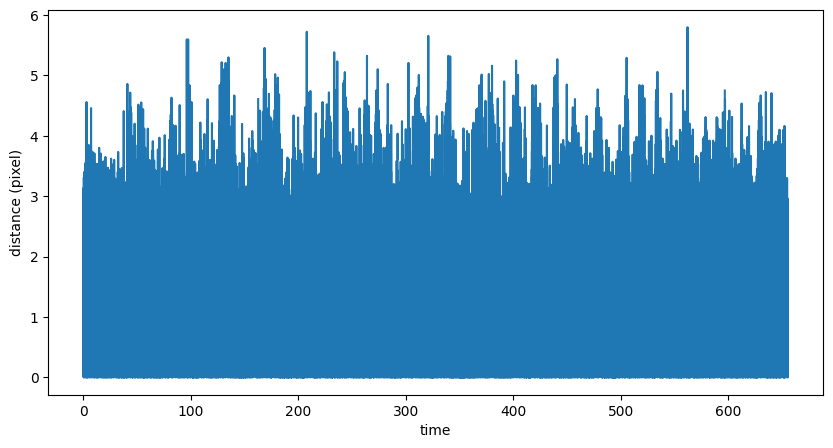

In [137]:
X_coord = coor_data_LIBRE['x_coordinate']
Y_coord = coor_data_LIBRE['y_coordinate']

t_axis_xy = (
    coor_data.index 
) / metadata["SamplingFrequency"]
distances = cal_diff_distance(X_coord, Y_coord)
print(distances.shape)

fig, ax= plt.subplots(figsize=(8, 4))
plt.plot(t_axis_xy[1:],
         distances)


plt.tick_params(axis='x', labelsize=10)
plt.tick_params(axis='y', labelsize=10)
plt.xlabel('time')
plt.ylabel('distance (pixel)')


(657900,)


Text(0, 0.5, 'distance (pixel)')

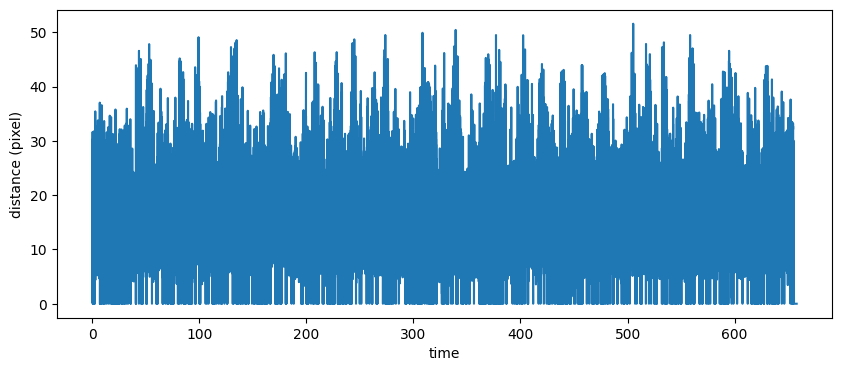

In [138]:
fig, ax= plt.subplots(figsize=(10, 4))
distances_win = cal_diff_sum_window(X_coord, Y_coord, window_size=7*2)
print(distances_win.shape)
plt.plot(t_axis_xy,
         distances_win)
plt.tick_params(axis='x', labelsize=10)
plt.tick_params(axis='y', labelsize=10)
plt.xlabel('time')
plt.ylabel('distance (pixel)')

Processing: 100%|█████████████████████| 657900/657900 [01:24<00:00, 7772.62it/s]


(657900,)


Text(0, 0.5, 'distance (pixel)')

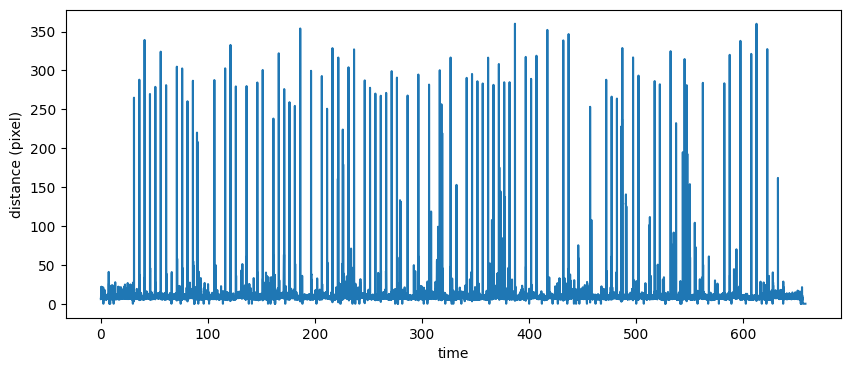

In [150]:
fig, ax= plt.subplots(figsize=(10, 4))
window_size = 80
distances_max_win = cal_max_distance_window(X_coord, Y_coord, window_size=window_size)
print(distances_win.shape)
plt.plot(t_axis_xy,
         distances_max_win)
plt.tick_params(axis='x', labelsize=10)
plt.tick_params(axis='y', labelsize=10)
plt.xlabel('time')
plt.ylabel('distance (pixel)')

In [153]:
save_mask_path = f'./masks_1206/subject_{subject_idx}_max_dist_win_{window_size}.mat'
sio.savemat(save_mask_path, {'distances_max_win': distances_max_win})
print(f'The mask file has been saved here: {save_mask_path}')
print(len(distances_max_win[distances_max_win>60]))
print(len(distances_max_win))

The mask file has been saved here: ./masks_1206/subject_1_max_dist_win_80.mat
2946
657900


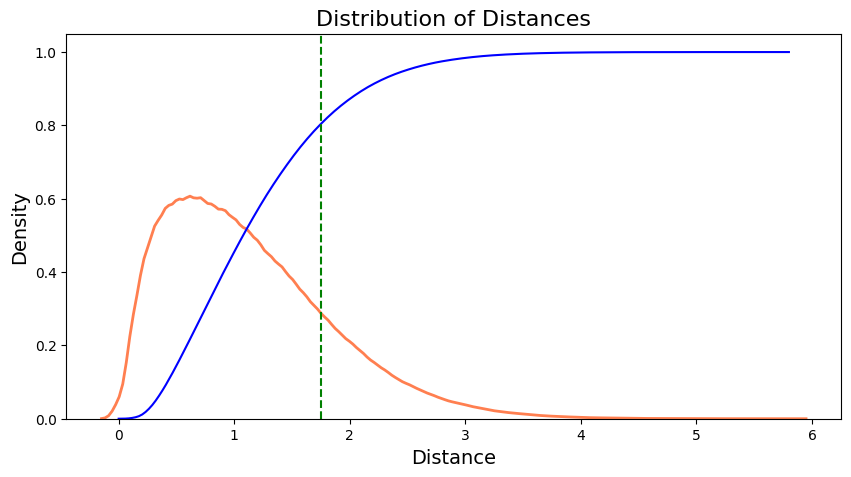

1.748739720799676


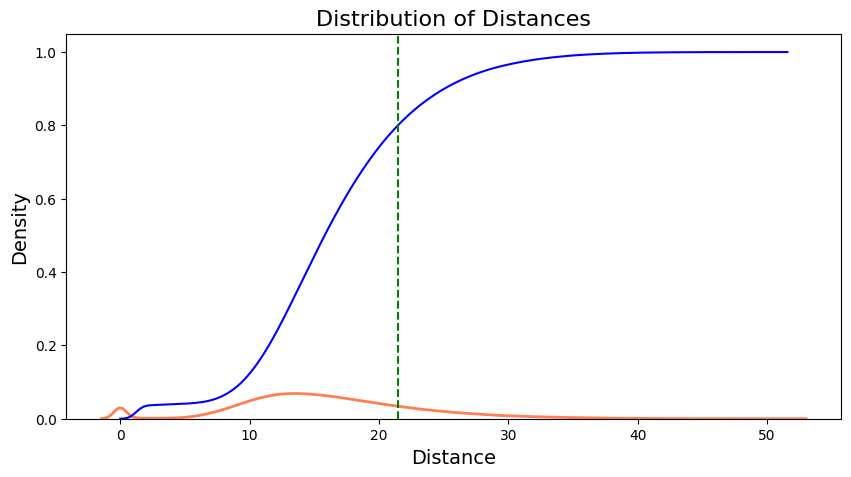

21.51341017672875


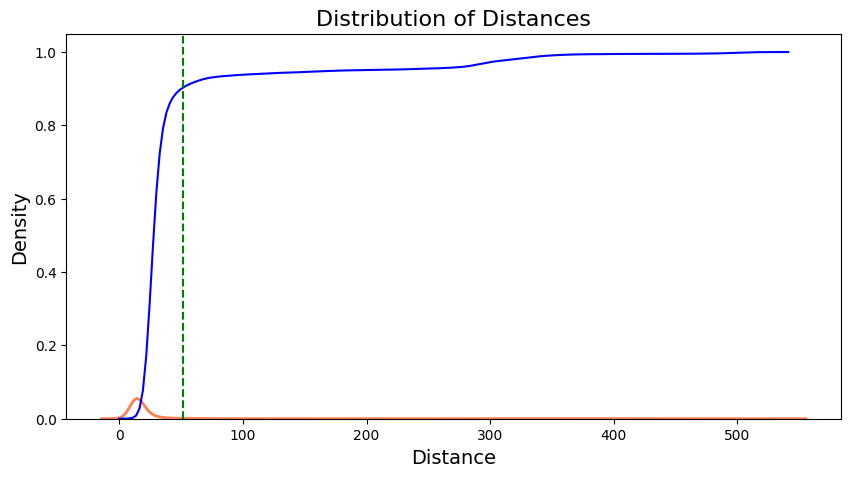

51.6691085454658


In [149]:
def plt_distribution(distances, threshold=0.8):
    import seaborn as sns

    # Filter out NaN values from the distances
    valid_distances = distances[~np.isnan(distances)]
    
    # Plot the distribution: KDE
    fig, ax= plt.subplots(figsize=(8, 4))

    kde_plot = sns.kdeplot(valid_distances, color='coral', linewidth=2, label='KDE Plot')
    # Get the x and y values from the plot (not the plot object itself)
    x_values = kde_plot.get_lines()[0].get_xdata()
    kde_values = kde_plot.get_lines()[0].get_ydata()
    # Add labels and legend
    ax.set_xlabel('Distance', fontsize=14)
    ax.set_ylabel('Density', fontsize=14)
    ax.set_title('Distribution of Distances', fontsize=16)


    # Plot the cdf values
   
    cdf_values = np.cumsum(kde_values)  # Cumulative sum
    # Normalize the CDF to range from 0 to 1
    cdf_values /= cdf_values[-1]
    x_values = np.linspace(min(valid_distances), max(valid_distances), len(cdf_values))  # Define x range
    ax.plot(x_values, cdf_values, label='CDF', color='blue')
    # Normalize the CDF to range from 0 to 1
    cdf_values /= cdf_values[-1]
    # Find the threshold value for 80% accumulation
    threshold_index = np.argmax(cdf_values >= threshold)
    threshold_value = x_values[threshold_index]
    
    ax.axvline(threshold_value, color='green', linestyle='--', label=f'80% Threshold: {threshold_value:.2f}')


    # Show plot
    plt.show()
    return threshold_value

threshold_value = plt_distribution(distances, threshold=0.8)
print(threshold_value)

threshold_value = plt_distribution(distances_win, threshold=0.8)
print(threshold_value)

threshold_value = plt_distribution(distances_max_win, threshold=0.9)
print(threshold_value)

In [154]:
def cal_statistics(distances):
    mean_distance = np.nanmean(distances)
    std_distance = np.nanstd(distances)
    median_distance = np.nanmedian(distances)
    min_distance = np.nanmin(distances)
    max_distance = np.nanmax(distances)
    nan_count = np.sum(np.isnan(distances))  # Count NaN values
    
    # Display the results
    print(f"Mean distance: {mean_distance:.2f}")
    print(f"Standard deviation: {std_distance:.2f}")
    print(f"Median distance: {median_distance:.2f}")
    print(f"Minimum distance: {min_distance:.2f}")
    print(f"Maximum distance: {max_distance:.2f}")
    print(f"Number of NaN values: {nan_count}")
    
cal_statistics(distances)
cal_statistics(distances_win)
cal_statistics(distances_max_win)

Mean distance: 1.12
Standard deviation: 0.71
Median distance: 1.00
Minimum distance: 0.00
Maximum distance: 5.80
Number of NaN values: 30960
Mean distance: 16.07
Standard deviation: 7.00
Median distance: 15.38
Minimum distance: 0.00
Maximum distance: 51.58
Number of NaN values: 0
Mean distance: 10.15
Standard deviation: 14.86
Median distance: 8.77
Minimum distance: 0.00
Maximum distance: 360.06
Number of NaN values: 0


## Generate movement distance mask

In [156]:
def generate_movement_mask(distances_max_win, offset, move_criteria):
    # Generate the mask
    # the threshold should be within voxel size, or some relationship with voxel size.
    distances_max_win = distances_max_win[offset:]
    
    move_discard_mask = (
        (distances_max_win > move_criteria) | np.isnan(distances_max_win)
        )
    move_preserve_mask = ~(move_discard_mask)
    
    
    # Check the result
    print("Mask shape:", move_preserve_mask.shape)

    return move_preserve_mask


# offset_first_trigger_mriStart = first trigger interval (according to log.txt) - (first mri meas - first marker)
if subject_idx == 1:
    offset_first_trigger_mriStart = round(1989.4 - 247.5)
elif subject_idx == 2:
    offset_first_trigger_mriStart = round(2006.6 - 1985)
else:
    offset_first_trigger_mriStart = round(1994 - 47.5)

move_criteria = 60
offset = offset_first_trigger_mriStart
move_preserve_mask = generate_movement_mask(distances_max_win, offset, move_criteria)

save_move_preserve_mask = True
if save_move_preserve_mask:
    save_mask_path = f'./masks_1206/subject_{subject_idx}_move_win{window_size}_crit{move_criteria}_mask.mat'
    sio.savemat(save_mask_path, {'move_preserve_mask': move_preserve_mask})
    print(f'The mask file has been saved here: {save_mask_path}')

Mask shape: (656158,)
The mask file has been saved here: ./masks_1206/subject_1_move_win80_crit60_mask.mat


## Generate the raw masks: 5 masks
According to the stimuli intervals

In [33]:
see_raw=False

if see_raw:
    coor_data_dot_raw = copy.deepcopy(coor_data_LIBRE_raw)
    
    print(len(coor_data_dot_raw))
    
    coor_data_dot_raw = coor_data_dot_raw.reset_index(drop=True)
    
    
    if subject_idx == 1:
        offset_first_dot_mriStart = 1244 #1243.9 -> 1244
    elif subject_idx == 2:
        offset_first_dot_mriStart = -475
    else:
        offset_first_dot_mriStart= 1451 #1450.5 -> 1451
    
    # I want to generate a table, concatenate the labels along with the recordings.
    # for example, I have 657402 coordinates pandas dataframe, and I have subsequent 131 intervals and 131 labels,
    # I want to add the labels to the dataframe as a new column according to the intervals.
    
    
    
    # Initialize a new column for labels
    coor_data_dot_raw['label'] = None
    
    # Assign labels based on intervals
    for i, dot_m in enumerate(dot_message):
        start = dot_m[0]
        end = start+intervals[i]
        coor_data_dot_raw.loc[start:end, 'label'] = labels[i]
    
    # Check result
    # print(coor_data_dot_raw[dot_message[19][0]:dot_message[19][0]+intervals[19]])
    


In [34]:
if see_raw:
    coor_data_dot_offset = coor_data_dot_raw[offset_first_dot_mriStart:].reset_index(drop=True)
    mri_duration = 655240
    coor_data_dot_offset = coor_data_dot_offset[:mri_duration]
    print(len(coor_data_dot_offset))
    print(coor_data_dot_offset)
    unique_labels = coor_data_dot_offset["label"].unique()
    print("Unique labels:", unique_labels)
    coor_data_dot_offset[coor_data_dot_offset["label"] == 'center'][-2000:-1990]

In [35]:
def generate_raw_mask(coor_data, label_type='label', label='up'):
    # Generate the mask
    raw_mask = np.where(coor_data[label_type] == label, 1, 0)
    
    # Check the result
    print("Mask:", raw_mask)
    print("Mask shape:", raw_mask.shape)

    
    return raw_mask
    
if see_raw:
    # Generate 5 raw mask
    import os
    import scipy.io as sio
    
    
    
    label_list = ['up', 'down', 'left', 'right', 'center', 'invalid']
    raw_mask_5p = []
    raw_mask_up = generate_raw_mask(coor_data_dot_offset, label_type='label', label=label_list[0])
    raw_mask_5p.append(raw_mask_up)
    
    raw_mask_down = generate_raw_mask(coor_data_dot_offset, label_type='label', label=label_list[1])
    raw_mask_5p.append(raw_mask_down)
    
    raw_mask_left = generate_raw_mask(coor_data_dot_offset, label_type='label', label=label_list[2])
    raw_mask_5p.append(raw_mask_left)
    
    raw_mask_right = generate_raw_mask(coor_data_dot_offset,label_type='label', label=label_list[3])
    raw_mask_5p.append(raw_mask_right)
    
    raw_mask_center = generate_raw_mask(coor_data_dot_offset,label_type='label', label=label_list[4])
    raw_mask_5p.append(raw_mask_center)
    
    coor_data_dot_offset[raw_mask_center.astype(bool)]
    
    save_mask = True
    if save_mask:
        for m_idx in range(5):
            save_mask_path = f'./masks/subject_{subject_idx}_raw_mask_{label_list[m_idx]}.mat'
            sio.savemat(save_mask_path, {'array': raw_mask_5p[m_idx]})
            print(f'The mask file has been saved here: {save_mask_path}')
            
      
    


## Generate the location masks: 5 masks
According to the absolute locations

In [36]:
coor_data_dot_raw = copy.deepcopy(coor_data_LIBRE_raw)
print(len(coor_data_dot_raw))
coor_data_dot_raw = coor_data_dot_raw.reset_index(drop=True)

# offset_first_trigger_mriStart = first trigger interval (according to log.txt) - (first mri meas - first marker)
if subject_idx == 1:
    offset_first_trigger_mriStart = round(1989.4 - 247.5)
elif subject_idx == 2:
    offset_first_trigger_mriStart = round(2006.6 - 1985)
else:
    offset_first_trigger_mriStart = round(1994 - 47.5)

# Initialize a new column for labels
coor_data_dot_raw['lc_label'] = None


coor_data_dot_offset = coor_data_dot_raw[offset_first_trigger_mriStart:].reset_index(drop=True)
mri_duration = 655240

coor_data_dot_offset = coor_data_dot_offset[:]
print(len(coor_data_dot_offset))
print(coor_data_dot_offset)




657900
656158
        x_coordinate  y_coordinate lc_label
0         402.500000    300.700012     None
1         402.899994    299.799988     None
2         403.000000    300.000000     None
3         402.399994    302.200012     None
4         401.700012    304.299988     None
...              ...           ...      ...
656153           NaN           NaN     None
656154           NaN           NaN     None
656155           NaN           NaN     None
656156           NaN           NaN     None
656157           NaN           NaN     None

[656158 rows x 3 columns]


In [37]:
# Define the ranges
# x_left_range = [500, 800]
# x_right_range = [0, 300]
# x_center_range = [300, 500]

# y_up_range = [0, 200]
# y_down_range = [400, 600]
# y_center_range = [200, 400]

left_range_x = [450, 800]
left_range_y = [150, 450]
right_range_x = [0, 350]
right_range_y = [150, 450]

up_range_x = [225, 575]
up_range_y = [0, 300]
down_range_x = [225, 575]
down_range_y = [300, 600]

center_range_x = [300, 500]
center_range_y = [200, 400]


# Function to classify coordinates
def classify_region(x, y):
    if (up_range_x[0] <= x <= up_range_x[1])&(up_range_y[0] <= y <= up_range_y[1]):
        return "up"
    elif (down_range_x[0] <= x <= down_range_x[1])&(down_range_y[0] <= y <= down_range_y[1]):
        return "down"
    elif (center_range_x[0] <= x <= center_range_x[1])&(center_range_y[0] <= y <= center_range_y[1]):
        return "center"
    elif (left_range_x[0] <= x <= left_range_x[1])&(left_range_y[0] <= y <= left_range_y[1]):
        return "left"
    elif (right_range_x[0] <= x <= right_range_x[1])&(right_range_y[0] <= y <= right_range_y[1]):
        return "right"
    else:        
        return "invalid"

# Apply the function to the DataFrame
coor_data_dot_offset['lc_label'] = coor_data_dot_offset.apply(lambda row: classify_region(row['x_coordinate'], row['y_coordinate']), axis=1)

# Display the resulting DataFrame
print(coor_data_dot_offset)
nan_counts_per_column = coor_data_dot_offset.isna().sum()
print(nan_counts_per_column)

        x_coordinate  y_coordinate lc_label
0         402.500000    300.700012     down
1         402.899994    299.799988       up
2         403.000000    300.000000       up
3         402.399994    302.200012     down
4         401.700012    304.299988     down
...              ...           ...      ...
656153           NaN           NaN  invalid
656154           NaN           NaN  invalid
656155           NaN           NaN  invalid
656156           NaN           NaN  invalid
656157           NaN           NaN  invalid

[656158 rows x 3 columns]
x_coordinate    8449
y_coordinate    8802
lc_label           0
dtype: int64


In [38]:
# Generate 5 raw mask
import os
import scipy.io as sio


label_list = ['up', 'down', 'left', 'right', 'center', 'invalid']
raw_mask_lc = []
raw_mask_up = generate_raw_mask(coor_data_dot_offset, label_type='lc_label', label=label_list[0])
print(np.sum(raw_mask_up))
raw_mask_lc.append(raw_mask_up)

raw_mask_down = generate_raw_mask(coor_data_dot_offset, label_type='lc_label', label=label_list[1])
print(np.sum(raw_mask_down))
raw_mask_lc.append(raw_mask_down)

raw_mask_left = generate_raw_mask(coor_data_dot_offset, label_type='lc_label', label=label_list[2])
print(np.sum(raw_mask_left))
raw_mask_lc.append(raw_mask_left)

raw_mask_right = generate_raw_mask(coor_data_dot_offset, label_type='lc_label', label=label_list[3])
print(np.sum(raw_mask_right))
raw_mask_lc.append(raw_mask_right)

raw_mask_center = generate_raw_mask(coor_data_dot_offset, label_type='lc_label', label=label_list[4])
print(np.sum(raw_mask_center))
raw_mask_lc.append(raw_mask_center)

coor_data_dot_offset[raw_mask_center.astype(bool)]

save_mask = True
if save_mask:
    for m_idx in range(5):
        save_mask_path = f'./masks/subject_{subject_idx}_lc_mask_{label_list[m_idx]}.mat'
        sio.savemat(save_mask_path, {'array': raw_mask_lc[m_idx]})
        print(f'The mask file has been saved here: {save_mask_path}')
        
  



Mask: [0 1 1 ... 0 0 0]
Mask shape: (656158,)
186531
Mask: [1 0 0 ... 0 0 0]
Mask shape: (656158,)
173746
Mask: [0 0 0 ... 0 0 0]
Mask shape: (656158,)
146410
Mask: [0 0 0 ... 0 0 0]
Mask shape: (656158,)
140273
Mask: [0 0 0 ... 0 0 0]
Mask shape: (656158,)
0
The mask file has been saved here: ./masks/subject_1_lc_mask_up.mat
The mask file has been saved here: ./masks/subject_1_lc_mask_down.mat
The mask file has been saved here: ./masks/subject_1_lc_mask_left.mat
The mask file has been saved here: ./masks/subject_1_lc_mask_right.mat
The mask file has been saved here: ./masks/subject_1_lc_mask_center.mat


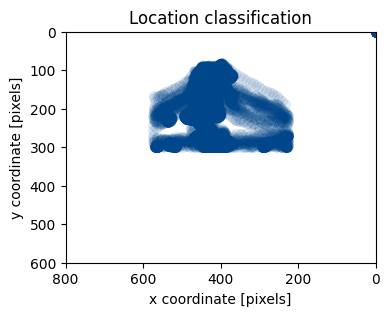

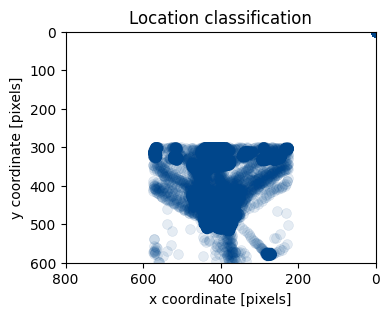

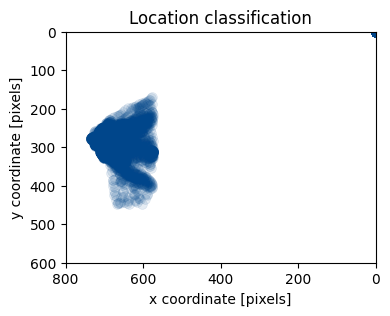

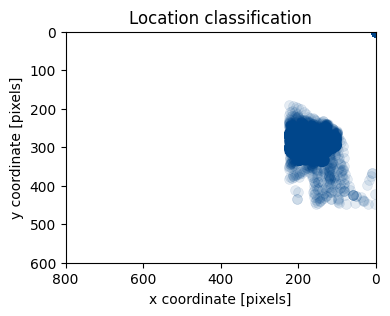

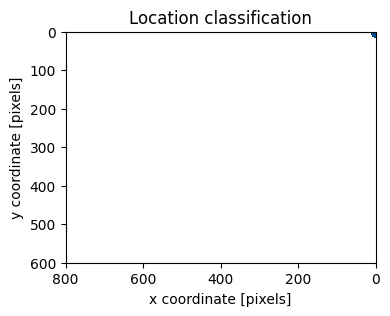

In [39]:
for idx in range(5):
    # Example data (replace with your actual data)
    if see_raw:
        X_coord = coor_data_dot_offset['x_coordinate']*raw_mask_5p[idx]
        Y_coord = coor_data_dot_offset['y_coordinate']*raw_mask_5p[idx]
        fig, ax= plt.subplots(figsize=(4, 3))
        # Plot the data, flipping X coordinates and using dots as markers
        plt.scatter(X_coord, Y_coord, s=50, c='#00468b', alpha=0.1, edgecolors='#00468b', linewidth=0.5)
        plt.xlim((0, 800))
        plt.ylim((0, 600))
        # Set plot title
        plt.title('Interval classification')
        plt.xlabel('x coordinate [pixels]')
        plt.ylabel('y coordinate [pixels]')
        # Reverse the direction of the Y-axis
        plt.gca().invert_yaxis()
        plt.gca().invert_xaxis()
    
    # ============================================================
    # Example data (replace with your actual data)
    X_coord = coor_data_dot_offset['x_coordinate']*raw_mask_lc[idx]
    Y_coord = coor_data_dot_offset['y_coordinate']*raw_mask_lc[idx]
    
    fig, ax= plt.subplots(figsize=(4, 3))
    # Plot the data, flipping X coordinates and using dots as markers
    plt.scatter(X_coord, Y_coord, s=50, c='#00468b', alpha=0.1, edgecolors='#00468b', linewidth=0.5)
    plt.xlim((0, 800))
    plt.ylim((0, 600))
    # Set plot title
    plt.title('Location classification')
    plt.xlabel('x coordinate [pixels]')
    plt.ylabel('y coordinate [pixels]')
    # Reverse the direction of the Y-axis
    plt.gca().invert_yaxis()
    plt.gca().invert_xaxis()
    # ============================================================
   

## Generate the filtered 5 mask
based on the filtered coordinate



In [40]:
# def find_mean(x)

coor_data_dot_filtered = copy.deepcopy(coor_data_LIBRE)
print(len(coor_data_dot_raw))
coor_data_dot_filtered = coor_data_dot_filtered.reset_index(drop=True)

if subject_idx == 1:
    offset_first_trigger_mriStart = round(1989.4 - 247.5)
elif subject_idx == 2:
    offset_first_trigger_mriStart = round(2006.6 - 1985)
else:
    offset_first_trigger_mriStart = round(1994 - 47.5)

coor_data_dot_filtered_offset = coor_data_dot_filtered[offset_first_trigger_mriStart:].reset_index(drop=True)
mri_duration = 655240
coor_data_dot_filtered_offset = coor_data_dot_filtered_offset[:]
print(len(coor_data_dot_filtered_offset))


nan_counts_per_column = coor_data_dot_filtered_offset.isna().sum()
print(f"\nnum of nan:\n{nan_counts_per_column} \n")

# Ensuring both coordinates are NaN if either is NaN
coor_data_dot_filtered_offset[['x_coordinate', 'y_coordinate']] = coor_data_dot_filtered_offset[['x_coordinate', 'y_coordinate']].apply(
    lambda row: row if not row.isna().any() else [np.nan, np.nan], axis=1
)
nan_counts_per_column = coor_data_dot_filtered_offset.isna().sum()
print(f"\nnum of nan:\n{nan_counts_per_column} \n")


coor_data_dot_filtered_offset['lc_label'] = coor_data_dot_offset['lc_label']
print(f'{len(coor_data_dot_filtered_offset)} -- {len(coor_data_dot_offset)}')
# print(coor_data_dot_filtered_offset)

# Here I want to clean all the NaN elements with label "invalid"
print(f"before processing: {len(coor_data_dot_filtered_offset[coor_data_dot_filtered_offset['lc_label'] == 'invalid'])}")
coor_data_dot_filtered_offset.loc[coor_data_dot_filtered_offset.isna().any(axis=1), 'lc_label'] = "invalid"
print(f"after processing: {len(coor_data_dot_filtered_offset[coor_data_dot_filtered_offset['lc_label'] == 'invalid'])}")

657900
656158

num of nan:
x_coordinate    30344
y_coordinate    30344
dtype: int64 


num of nan:
x_coordinate    30344
y_coordinate    30344
dtype: int64 

656158 -- 656158
before processing: 9198
after processing: 30344


In [41]:
label_list = ['up', 'down', 'left', 'right', 'center', 'invalid']
ft_mask_list = []
ft_mask_up = generate_raw_mask(coor_data_dot_filtered_offset, label_type='lc_label', label=label_list[0])
print(np.sum(ft_mask_up))
ft_mask_list.append(ft_mask_up)

ft_mask_down = generate_raw_mask(coor_data_dot_filtered_offset, label_type='lc_label', label=label_list[1])
print(np.sum(ft_mask_down))
ft_mask_list.append(ft_mask_down)

ft_mask_left = generate_raw_mask(coor_data_dot_filtered_offset, label_type='lc_label', label=label_list[2])
print(np.sum(ft_mask_left))
ft_mask_list.append(ft_mask_left)

ft_mask_right = generate_raw_mask(coor_data_dot_filtered_offset, label_type='lc_label', label=label_list[3])
print(np.sum(ft_mask_right))
ft_mask_list.append(ft_mask_right)

ft_mask_center = generate_raw_mask(coor_data_dot_filtered_offset, label_type='lc_label', label=label_list[4])
print(np.sum(ft_mask_center))
ft_mask_list.append(ft_mask_center)

coor_data_dot_filtered_offset[ft_mask_center.astype(bool)]

save_mask = True
if save_mask:
    for m_idx in range(5):
        save_mask_path = f'./masks/subject_{subject_idx}_ft_mask_{label_list[m_idx]}.mat'
        sio.savemat(save_mask_path, {'array': ft_mask_list[m_idx]})
        print(f'The mask file has been saved here: {save_mask_path}')
        
  


Mask: [0 1 1 ... 0 0 0]
Mask shape: (656158,)
179497
Mask: [1 0 0 ... 0 0 0]
Mask shape: (656158,)
168256
Mask: [0 0 0 ... 0 0 0]
Mask shape: (656158,)
141776
Mask: [0 0 0 ... 0 0 0]
Mask shape: (656158,)
136285
Mask: [0 0 0 ... 0 0 0]
Mask shape: (656158,)
0
The mask file has been saved here: ./masks/subject_1_ft_mask_up.mat
The mask file has been saved here: ./masks/subject_1_ft_mask_down.mat
The mask file has been saved here: ./masks/subject_1_ft_mask_left.mat
The mask file has been saved here: ./masks/subject_1_ft_mask_right.mat
The mask file has been saved here: ./masks/subject_1_ft_mask_center.mat


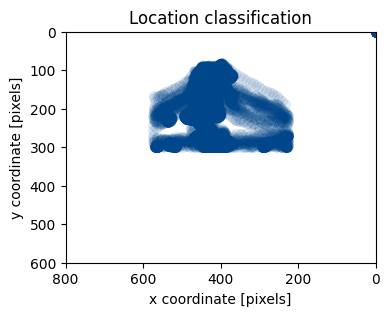

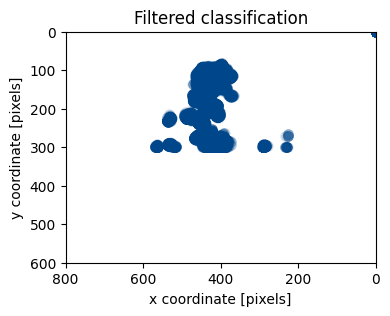

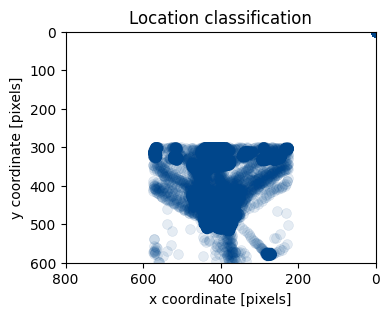

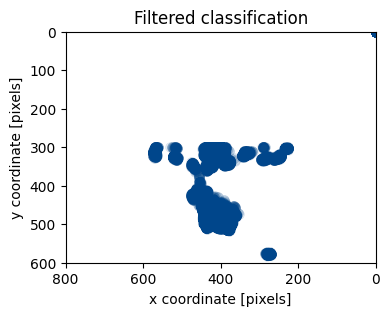

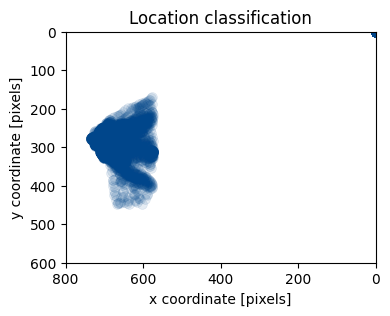

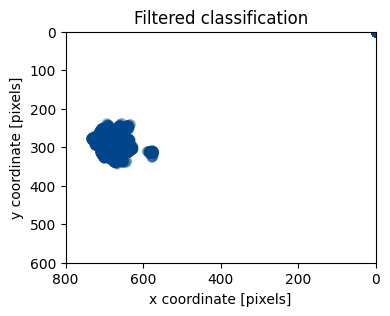

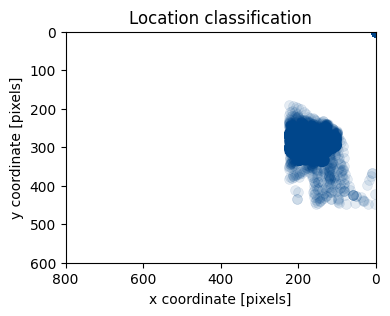

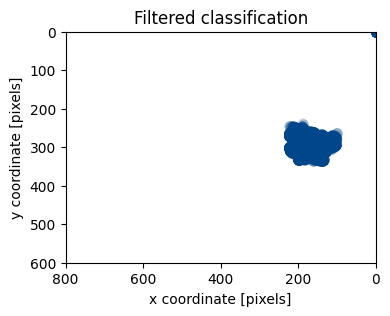

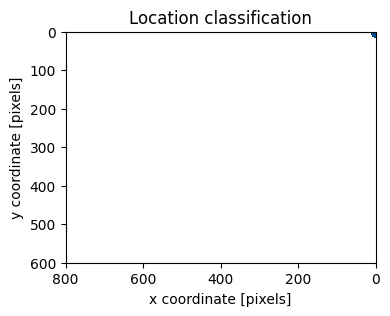

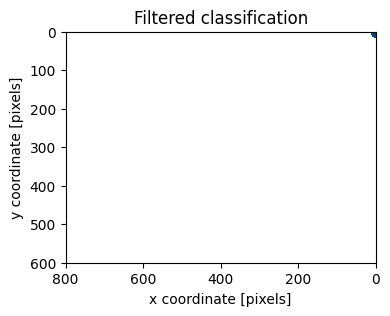

In [42]:
for idx in range(5):
    # ============================================================
    # Example data (replace with your actual data)
    X_coord = coor_data_dot_offset['x_coordinate']*raw_mask_lc[idx]
    Y_coord = coor_data_dot_offset['y_coordinate']*raw_mask_lc[idx]
    
    fig, ax= plt.subplots(figsize=(4, 3))
    # Plot the data, flipping X coordinates and using dots as markers
    plt.scatter(X_coord, Y_coord, s=50, c='#00468b', alpha=0.1, edgecolors='#00468b', linewidth=0.5)
    plt.xlim((0, 800))
    plt.ylim((0, 600))
    # Set plot title
    plt.title('Location classification')
    plt.xlabel('x coordinate [pixels]')
    plt.ylabel('y coordinate [pixels]')
    # Reverse the direction of the Y-axis
    plt.gca().invert_yaxis()
    plt.gca().invert_xaxis()
    
    # ============================================================
    # Example data (replace with your actual data)
    X_coord = coor_data_dot_filtered_offset['x_coordinate']*ft_mask_list[idx]
    Y_coord = coor_data_dot_filtered_offset['y_coordinate']*ft_mask_list[idx]
    fig, ax= plt.subplots(figsize=(4, 3))
    # Plot the data, flipping X coordinates and using dots as markers
    plt.scatter(X_coord, Y_coord, s=50, c='#00468b', alpha=0.1, edgecolors='#00468b', linewidth=0.5)
    plt.xlim((0, 800))
    plt.ylim((0, 600))
    # Set plot title
    plt.title('Filtered classification')
    plt.xlabel('x coordinate [pixels]')
    plt.ylabel('y coordinate [pixels]')
    # Reverse the direction of the Y-axis
    plt.gca().invert_yaxis()
    plt.gca().invert_xaxis()
    
    np.sum(raw_mask_lc[0] != ft_mask_list[0] )

### Filtered the coor_data_dot_filtered_offset

Region by the gaze points


To find the median coor of the point clouds
The mean position of the gaze region: [683.4000244140625, 283.70001220703125] (px)
To calculate visual angles w.r.t. points
656158
To calculate the displacement in both directions (mm)
656158
To generate discard masks for x and y direction...


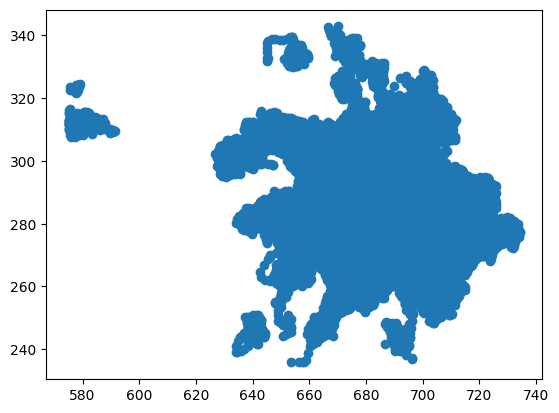

In [43]:
from mask_clean import find_mean_position, cal_angles, cal_disp, filter_criteria
from mask_clean import filter_XY_with_mask, visualization_func, plot_h_v_disp

# left mask
coor_data_left = copy.deepcopy(coor_data_dot_filtered_offset)

coor_data_left['x_coordinate'] = coor_data_left['x_coordinate']*ft_mask_list[2]
coor_data_left['y_coordinate'] = coor_data_left['y_coordinate']*ft_mask_list[2]
mask_zero = (coor_data_left['x_coordinate'] == 0) & (coor_data_left['y_coordinate'] == 0)
coor_data_left.loc[mask_zero, ['x_coordinate'] ] = np.nan
coor_data_left.loc[mask_zero, ['y_coordinate'] ] = np.nan

X_coord_left = coor_data_left['x_coordinate']
Y_coord_left = coor_data_left['y_coordinate']
# print(X_coord_left)
# print(Y_coord_left)
plt.scatter(X_coord_left, Y_coord_left)

med_coor_left = find_mean_position(X_coord_left, Y_coord_left)
theta_h_, theta_h_m, rho_v_, rho_v_m = cal_angles(X_coord_left, Y_coord_left, med_coor_left)
print(len(theta_h_))
h_dis_left, v_dis_left = cal_disp(theta_h_, theta_h_m, rho_v_, rho_v_m)
print(len(v_dis_left))

# print(v_dis_left)
criteria_ratio=0.3
discarded_x_mask, discarded_y_mask = filter_criteria(h_dis_left, v_dis_left, criteria_ratio=criteria_ratio)
# preserve_mask = ~(discarded_x_mask | discarded_y_mask)



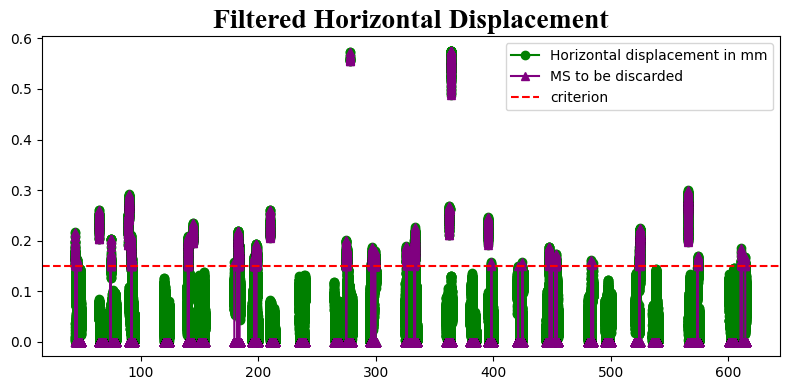

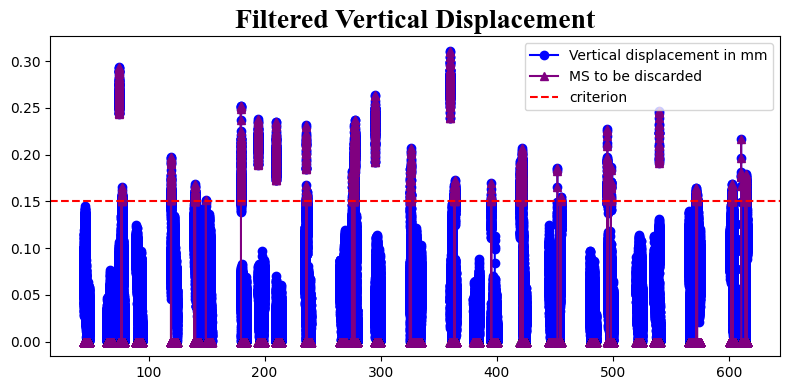

In [44]:
plot_h_v_disp(h_dis_left, v_dis_left, discarded_x_mask, 
              discarded_y_mask, criteria_ratio=criteria_ratio)



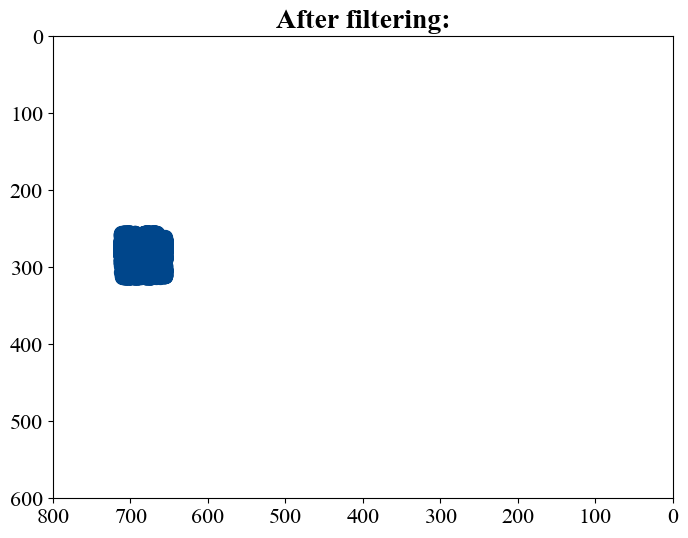

In [45]:
coor_data_left_clean, Preserve_mask, Discard_mask = filter_XY_with_mask(coor_data_left, discarded_x_mask, 
                                                                        discarded_y_mask, seq_name=None)


====
x_coordinate --- statistics
Mean distance: 683.69
Standard deviation: 13.11
Median distance: 683.10
Minimum distance: 655.10
Maximum distance: 711.80
Number of NaN values: 527290

====
y_coordinate --- statistics
Mean distance: 284.47
Standard deviation: 11.11
Median distance: 283.50
Minimum distance: 255.20
Maximum distance: 312.20
Number of NaN values: 527290


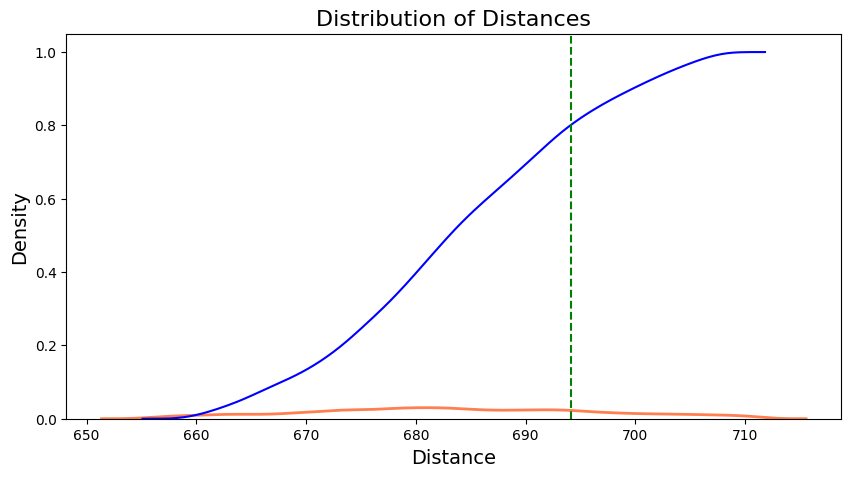

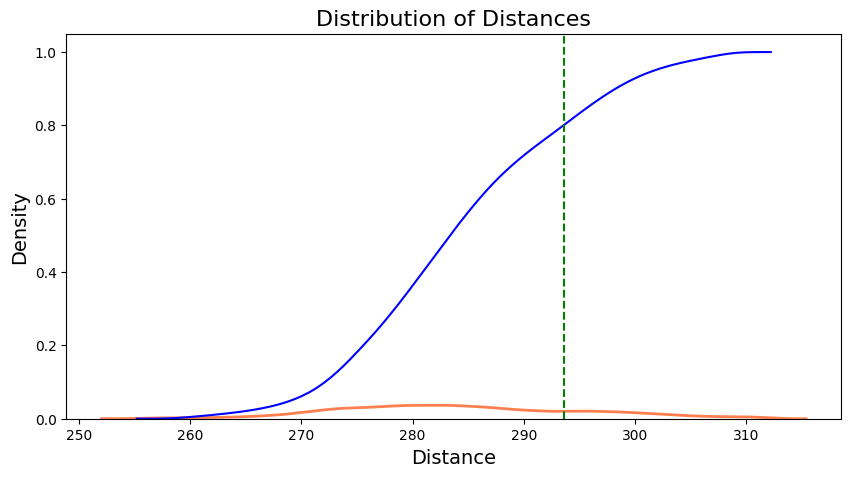

In [46]:
print('\n====\nx_coordinate --- statistics')
cal_statistics(coor_data_left_clean['x_coordinate'])
print('\n====\ny_coordinate --- statistics')
cal_statistics(coor_data_left_clean['y_coordinate'])
threshold_value_x = plt_distribution(coor_data_left_clean['x_coordinate'], threshold=0.8)
threshold_value_y = plt_distribution(coor_data_left_clean['y_coordinate'], threshold=0.8)

sum of raw mask: 146410
sum of filtered mask: 141776
sum of mask clean: 128868


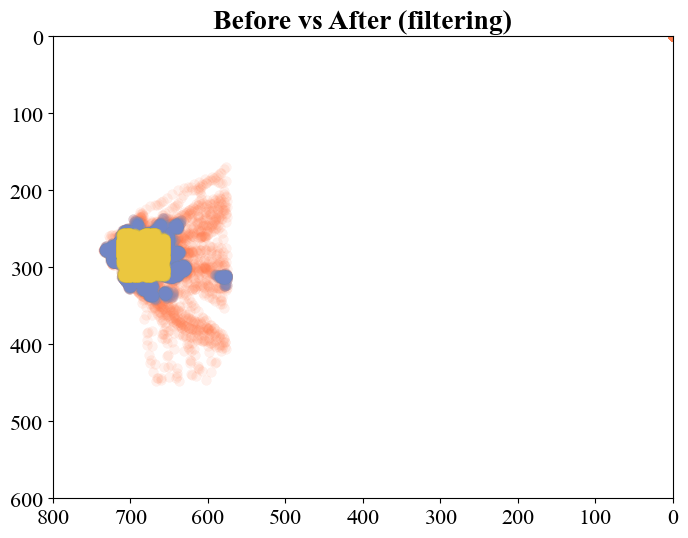

In [47]:

# Visualization of filtered coor data LIBRE
coor_data_raw_left = copy.deepcopy(coor_data_dot_offset)

coor_data_raw_left['x_coordinate'] = coor_data_raw_left['x_coordinate']*raw_mask_lc[2]
coor_data_raw_left['y_coordinate'] = coor_data_raw_left['y_coordinate']*raw_mask_lc[2]
print(f'sum of raw mask: {sum(raw_mask_lc[2])}')
print(f'sum of filtered mask: {sum(ft_mask_list[2])}')
print(f'sum of mask clean: {sum(Preserve_mask)}')
visualization_func(fig_title='Before vs After (filtering)', 
                   coor_data_raw = coor_data_raw_left, coor_data=coor_data_left, coor_data_clean=coor_data_left_clean)



In [48]:
count_true = np.sum(Preserve_mask)
print(count_true)
# Save the Preserve_mask
import os
import scipy.io as sio
save_mask = True

if save_mask:
    mask_name = f'subject_{subject_idx}_mask_clean_{criteria_ratio}_2.mat'
    if subject_idx == 1:
        SAVE_PATH = './masks/'
    elif subject_idx == 2:
        SAVE_PATH = './masks/'
    elif subject_idx == 3:
        SAVE_PATH = './masks/'
 
    
    # Create the folder if it doesn't exist
    os.makedirs(SAVE_PATH, exist_ok=True)
    mask_file = SAVE_PATH + mask_name

    # Save array to a .mat file
    sio.savemat(mask_file, {'array': Preserve_mask})
    print(f'The mask file has been saved here: {mask_file}')

128868
The mask file has been saved here: ./masks/subject_1_mask_clean_0.3_2.mat


In [49]:
save_Discard_mask = False
print(len(Preserve_mask))
if save_Discard_mask:
    Discard_mask = ~Preserve_mask
    count_true = np.sum(Discard_mask)
    print(count_true)
    # Save the Preserve_mask
    import os
    import scipy.io as sio

    mask_name = f'{FILE_NAME}_discard_mask_meth2_0_33.mat'
    if subject_idx == 1:
        SAVE_PATH = Path("/Users/cag/Documents/Dataset/1_Pilot_MREye_Data/Sub001/230928_anatomical_MREYE_study/ET_EDF/meth2_0_33/")
    elif subject_idx == 2:
        SAVE_PATH = Path("/Users/cag/Documents/Dataset/1_Pilot_MREye_Data/Sub002/230926_anatomical_MREYE_study/ET_EDF/meth2_0_33/")
    elif subject_idx == 3:
        SAVE_PATH = Path("/Users/cag/Documents/Dataset/1_Pilot_MREye_Data/Sub003/230928_anatomical_MREYE_study/ET_EDF/meth2_0_33/")
    else:
         SAVE_PATH = Path("/Users/cag/Documents/Dataset/1_Pilot_MREye_Data/Sub004/230923_anatomical_MREYE_study/ET_EDF/meth2_0_33/")

    # Create the folder if it doesn't exist
    os.makedirs(SAVE_PATH, exist_ok=True)
    mask_file = SAVE_PATH / mask_name

    # Save array to a .mat file
    sio.savemat(mask_file, {'array': Discard_mask})
    print(f'The mask file has been saved here: {mask_file}')

656158


# Multiple Masks

if num=4, divide the valid range into 4 parts


Processing region up
To find the median coor of the point clouds
The mean position of the gaze region: [422.1000061035156, 119.5999984741211] (px)
To calculate visual angles w.r.t. points
656158
To calculate the displacement in both directions (mm)
656158
To generate discard masks for x and y direction...
=====
x coordinate statistics:
Mean distance: 421.74
Standard deviation: 13.23
Median distance: 421.90
Minimum distance: 394.20
Maximum distance: 450.00
Number of NaN values: 542504
=====
y coordinate statistics:
Mean distance: 116.00
Standard deviation: 10.17
Median distance: 114.30
Minimum distance: 90.90
Maximum distance: 148.20
Number of NaN values: 542504
sum of raw mask: 186531
sum of filtered mask: 179497
sum of mask clean: 113654
The mask file has been saved here: ./masks/subject_1_mask_clean_0.3_0.mat

Processing region down
To find the median coor of the point clouds
The mean position of the gaze region: [410.2000122070313, 475.7999877929688] (px)
To calculate visual angles

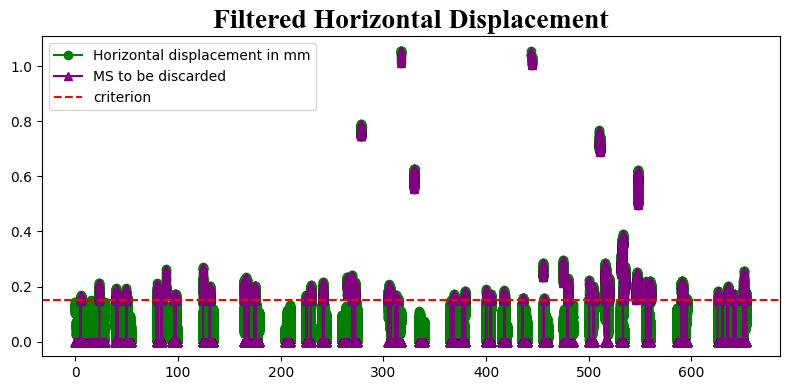

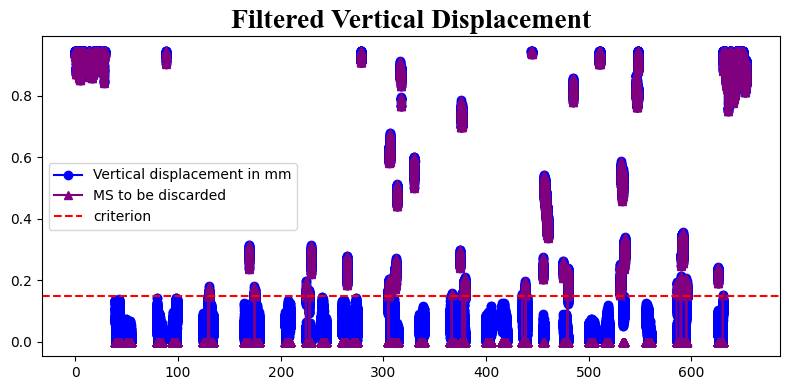

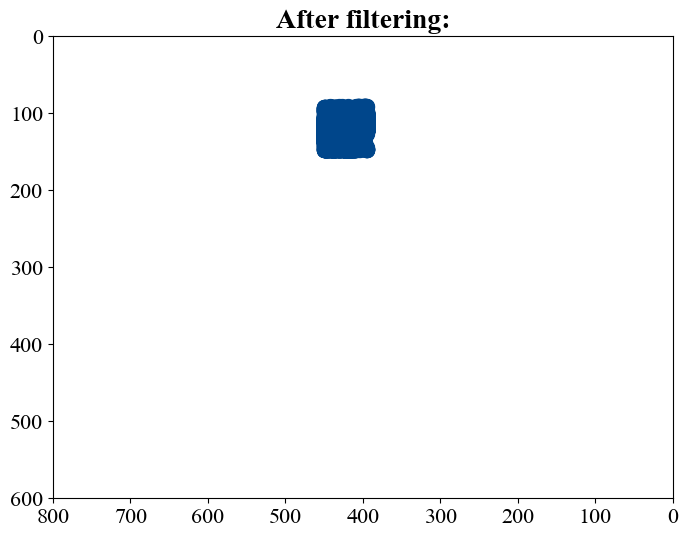

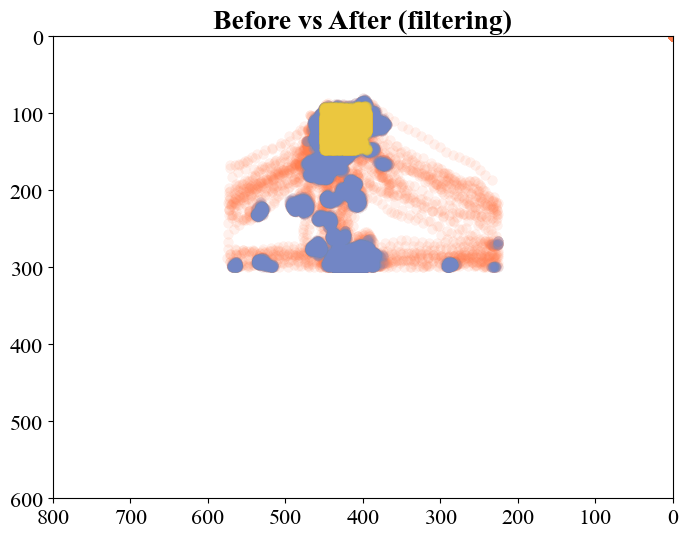

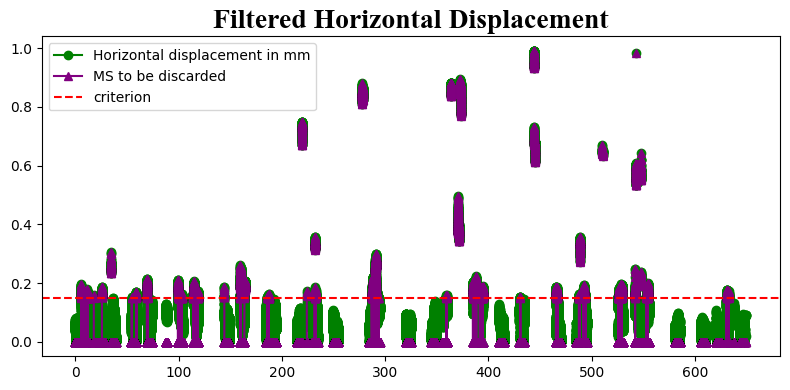

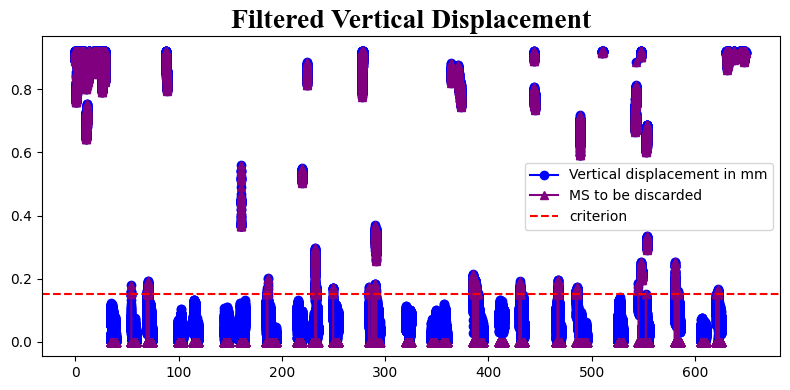

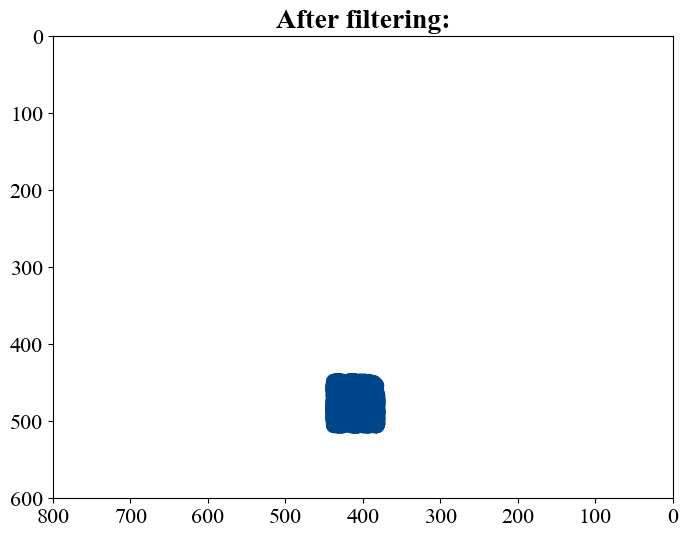

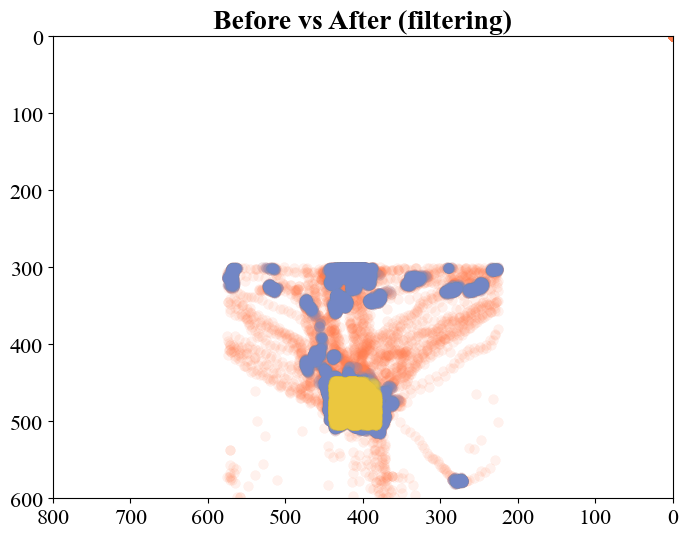

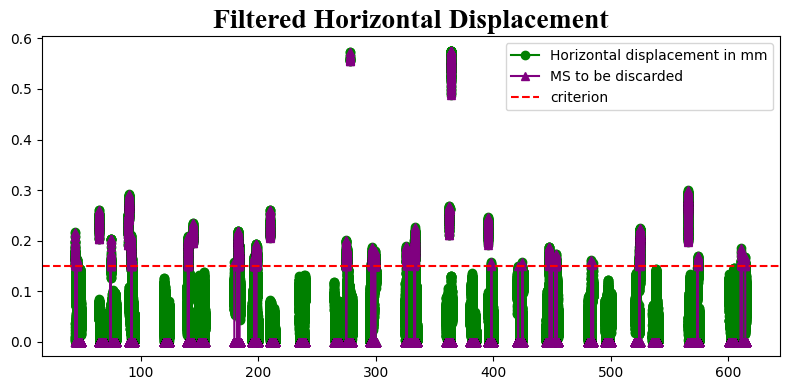

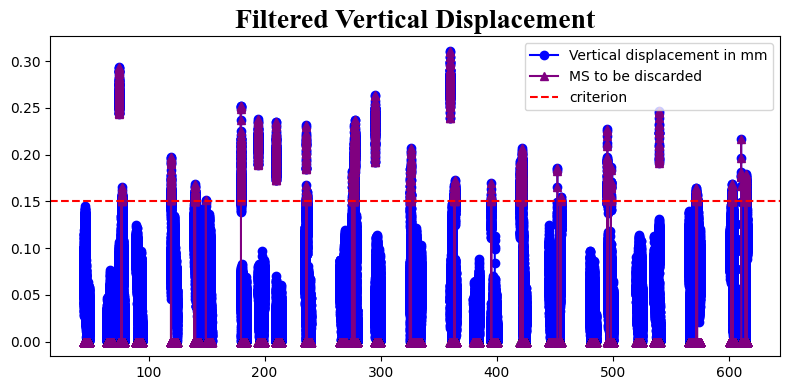

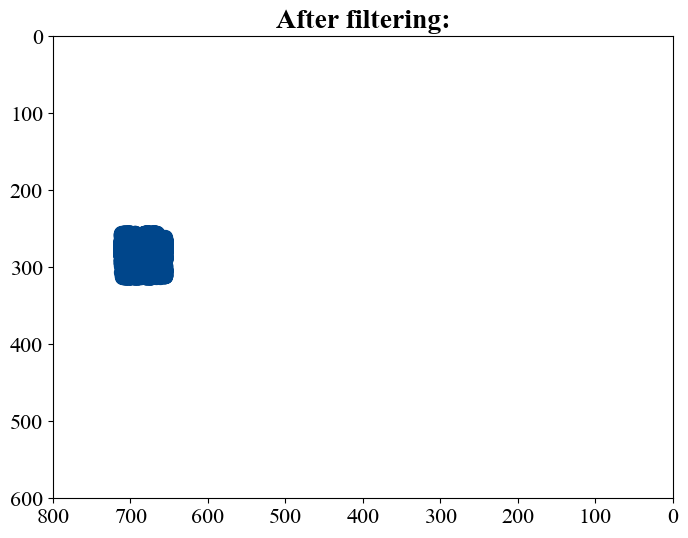

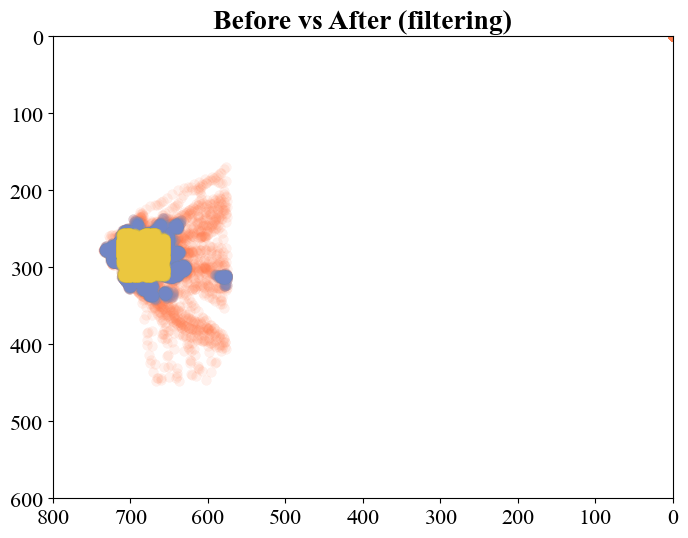

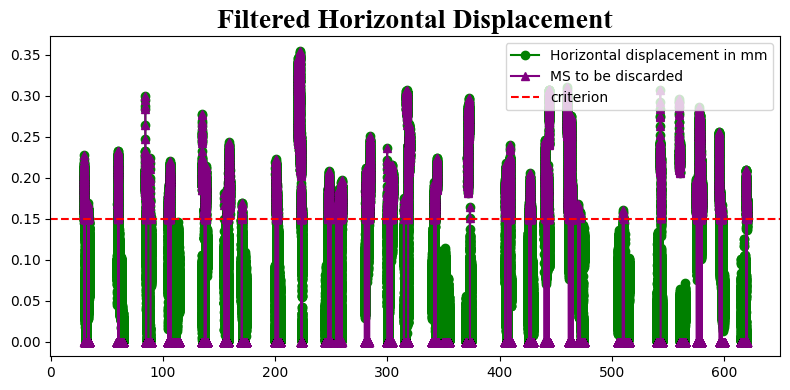

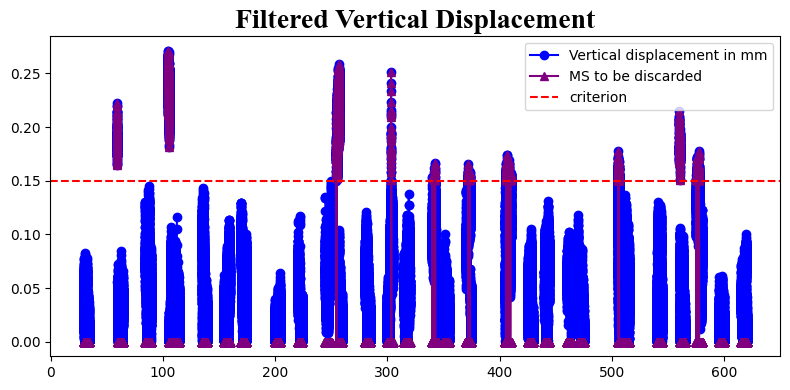

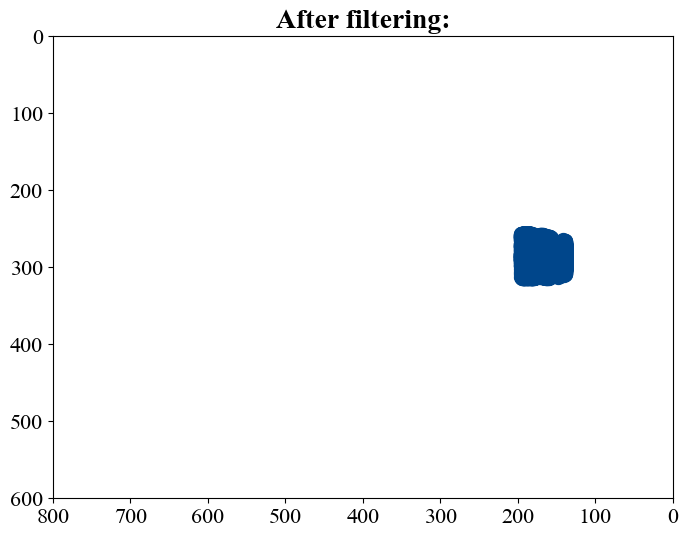

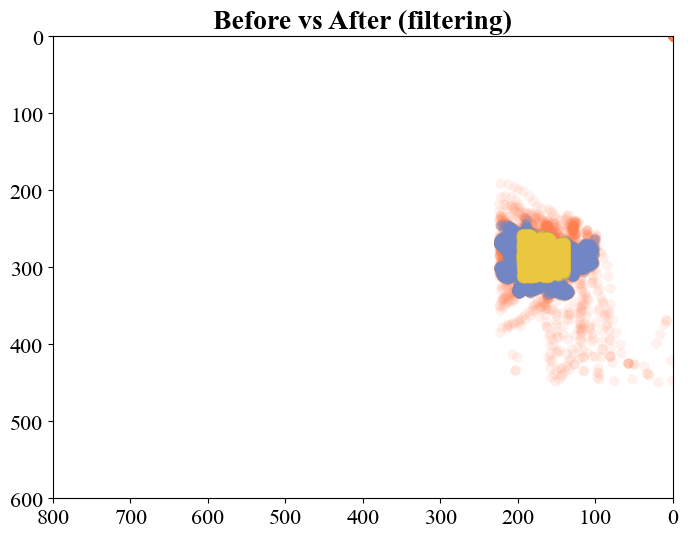

In [50]:
from mask_clean import find_mean_position, cal_angles, cal_disp, filter_criteria, filter_XY_with_mask, visualization_func
Preserve_mask_list = []
for region_idx in range(4):
    # 0:up 1:down 2:left 3:right 4:center mask
    print(f'\n=======\nProcessing region {label_list[region_idx]}')
    coor_data_region = copy.deepcopy(coor_data_dot_filtered_offset)

    coor_data_region['x_coordinate'] = coor_data_region['x_coordinate']*ft_mask_list[region_idx]
    coor_data_region['y_coordinate'] = coor_data_region['y_coordinate']*ft_mask_list[region_idx]
    mask_zero = (coor_data_region['x_coordinate'] == 0) & (coor_data_region['y_coordinate'] == 0)
    coor_data_region.loc[mask_zero, ['x_coordinate'] ] = np.nan
    coor_data_region.loc[mask_zero, ['y_coordinate'] ] = np.nan
    
    X_coord_region = coor_data_region['x_coordinate']
    Y_coord_region = coor_data_region['y_coordinate']


    med_coor_region = find_mean_position(X_coord_region, Y_coord_region)
    theta_h_, theta_h_m, rho_v_, rho_v_m = cal_angles(X_coord_region, Y_coord_region, med_coor_region)
    print(len(theta_h_))
    h_dis_region, v_dis_region = cal_disp(theta_h_, theta_h_m, rho_v_, rho_v_m)
    print(len(v_dis_region))

    # print(v_dis_region)
    criteria_ratio=0.3
    discarded_x_mask, discarded_y_mask = filter_criteria(h_dis_region, v_dis_region, criteria_ratio=criteria_ratio)
    # preserve_mask = ~(discarded_x_mask | discarded_y_mask)
    # =================================================================================
    plot_h_v_disp(h_dis_region, v_dis_region, discarded_x_mask, discarded_y_mask, criteria_ratio=criteria_ratio)
    
    coor_data_region_clean, Preserve_mask, Discard_mask = filter_XY_with_mask(coor_data_region, discarded_x_mask, 
                                                                            discarded_y_mask, seq_name=None)
    Preserve_mask_list.append(Preserve_mask)
    print('=====\nx coordinate statistics:')
    cal_statistics(coor_data_region_clean['x_coordinate'])
    print('=====\ny coordinate statistics:')
    cal_statistics(coor_data_region_clean['y_coordinate'])
    # ================================================================================= 
    # Visualization of filtered coor data LIBRE
    coor_data_raw_region = copy.deepcopy(coor_data_dot_offset)
    coor_data_raw_region['x_coordinate'] = coor_data_raw_region['x_coordinate']*raw_mask_lc[region_idx]
    coor_data_raw_region['y_coordinate'] = coor_data_raw_region['y_coordinate']*raw_mask_lc[region_idx]
    print(f'sum of raw mask: {sum(raw_mask_lc[region_idx])}')
    print(f'sum of filtered mask: {sum(ft_mask_list[region_idx])}')
    print(f'sum of mask clean: {sum(Preserve_mask)}')
    visualization_func(fig_title='Before vs After (filtering)', 
                       coor_data_raw = coor_data_raw_region, coor_data=coor_data_region, coor_data_clean=coor_data_region_clean)

    # ================================================================================= 
    
    # Save the Preserve_mask
    import os
    import scipy.io as sio
    save_mask = True
    
    if save_mask:
        mask_name = f'subject_{subject_idx}_mask_clean_{criteria_ratio}_{region_idx}.mat'
        SAVE_PATH = './masks/'
            
        # Create the folder if it doesn't exist
        os.makedirs(SAVE_PATH, exist_ok=True)
        mask_file = SAVE_PATH + mask_name
    
        # Save array to a .mat file
        sio.savemat(mask_file, {'array': Preserve_mask})
        print(f'The mask file has been saved here: {mask_file}')


In [51]:
print(len(Preserve_mask_list))
print(len(Preserve_mask_list[0]))

4
656158


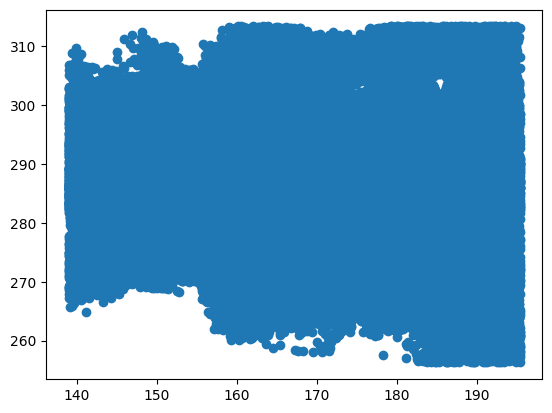

In [52]:
plt.scatter(coor_data_region_clean['x_coordinate'], coor_data_region_clean['y_coordinate'])

In [53]:
coor_data_region_clean[coor_data_region_clean['x_coordinate']==0]

,x_coordinate,y_coordinate,lc_label
